# FX Risk Reversal Momentum Strategy

## Abstract

This notebook implements and analyses a momentum strategy based on the risk reversal skew in FX options markets. The signal exploits persistent directional shifts in the 25-delta risk reversal — the implied volatility spread between out-of-the-money calls and puts — as a predictor of spot returns. The strategy is constructed step by step from raw market data through signal generation to P&L attribution, and is evaluated across four G10 currency pairs.

## Table of Contents

1. [Background](#1.-Background)
2. [Signal Construction](#2.-Signal-Construction)
3. [EURUSD Strategy: Class-Based Analysis](#3.-EURUSD-Strategy:-Class-Based-Analysis)
4. [Multi-Currency Analysis](#4.-Multi-Currency-Analysis)

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os
import sys

In [21]:
%config InlineBackend.figure_format = 'retina'
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [22]:
project_root = os.path.abspath("../..")
sys.path.append(project_root)
print("Project root:", project_root)

from FX_strategies.risk_reversal_signal import RiskReversalMomentum

Project root: /Users/anacontreras/Documents/Projects/RiskAlphaEngine


## 1. Background

### 1.1 FX Risk Reversal

The 25-delta risk reversal (RR) is the implied volatility spread between an out-of-the-money call and an out-of-the-money put at the same absolute delta:

$$RR_{25\Delta} = \sigma_{\text{call},\,25\Delta} - \sigma_{\text{put},\,25\Delta}$$

A **positive** RR indicates the market prices upside optionality more expensively than downside (bullish skew); a **negative** RR indicates the opposite. Because option skew tends to persist during sustained directional positioning or macro regime shifts, a change in RR — its first difference $\Delta RR_t = RR_t - RR_{t-1}$ — acts as a leading indicator of spot momentum.

The strategy converts this signal into a continuous position in $[-1,\,+1]$ via an EWMA-based t-statistic and a bounded smoothing function, described in detail in Section 2.

### 1.2 Dataset Description

The dataset covers daily observations for four G10 currency pairs starting December 2005: **EURUSD**, **GBPUSD**, **EURCHF**, and **USDCHF**. All pairs share an identical column schema.

| Column | Description | Units |
|--------|-------------|-------|
| `Spot` | FX spot rate (base/quote) | — |
| `ImpVol` | ATM 1-month implied volatility | decimal (e.g. 0.09 = 9%) |
| `RiskRev` | 25-delta risk reversal | volatility points |
| `Bfly` | 25-delta butterfly spread | volatility points |
| `IR_X` | Domestic interest rate | % per annum |
| `IR_Y` | Foreign interest rate | % per annum |

In [23]:
DATA_PATH = "../../data/"

data = pd.read_csv(
    DATA_PATH + "mktdata_EURUSD.csv",
    index_col=0,
    parse_dates=True,
    dayfirst=True
).dropna()

print(f"Shape:      {data.shape}")
print(f"Date range: {data.index[0].date()} to {data.index[-1].date()}")
data.head()

Shape:      (3860, 6)
Date range: 2005-12-12 to 2020-09-30


,Spot,ImpVol,RiskRev,Bfly,IR_X,IR_Y
date,,,,,,
2005-12-12,1.1974,0.09025,0.100,0.15,2.5437,4.36750
2005-12-13,1.1935,0.08900,0.100,0.15,2.5466,4.36938
2005-12-14,1.2019,0.09025,0.200,0.15,2.5516,4.37000
2005-12-15,1.1957,0.08775,0.150,0.15,2.5554,4.37000
2005-12-16,1.2007,0.08525,0.125,0.15,2.5585,4.37000


In [24]:
data.describe().round(4)

,Spot,ImpVol,RiskRev,Bfly,IR_X,IR_Y
count,3860.0000,3860.0000,3860.0000,3860.0000,3860.0000,3860.0000
mean,1.2638,0.0921,-0.5458,0.2143,0.7350,1.4340
std,0.1290,0.0346,0.8453,0.1202,1.6309,1.7220
min,1.0384,0.0381,-4.2125,0.0055,-2.8756,0.1448
25%,1.1354,0.0682,-0.9250,0.1500,-0.3581,0.2106
50%,1.2752,0.0845,-0.4250,0.1813,0.0934,0.4352
75%,1.3584,0.1088,0.0904,0.2490,1.0368,2.2668
max,1.5990,0.2862,2.8000,1.1625,5.4168,5.8238


## 2. Signal Construction

The strategy translates changes in the risk reversal skew into a bounded position signal through four sequential stages. The table below summarises each stage; the subsections that follow derive and implement each in turn.

| Stage | Input | Output | Formula |
|-------|-------|--------|---------|
| 1 | Spot price $S_t$ | Log return $r_t$ | $r_t = \ln(S_t / S_{t-1})$ |
| 2 | Risk reversal $RR_t$ | First difference $\Delta RR_t$ | $\Delta RR_t = RR_t - RR_{t-1}$ |
| 3 | $\Delta RR_t$ | EWMA t-statistic $e_t$ | $e_t = \hat{\beta}_t / \widehat{SE}_t$ |
| 4 | $e_t$ | Smoothed position $f(e_t) \in [-1, 1]$ | $f(e) = \sin\!\left(\frac{e\pi}{2}\right)$ if $|e| \le 1$, else $\text{sign}(e)$ |

### Stage 1: Log Return

The spot log return is defined as:

$$r_t = \ln\!\left(\frac{S_t}{S_{t-1}}\right)$$

Log returns are used throughout because they are time-additive — multi-period returns sum rather than compound — approximately normally distributed over short horizons, and symmetric with respect to base/quote currency inversion, a natural property for FX.

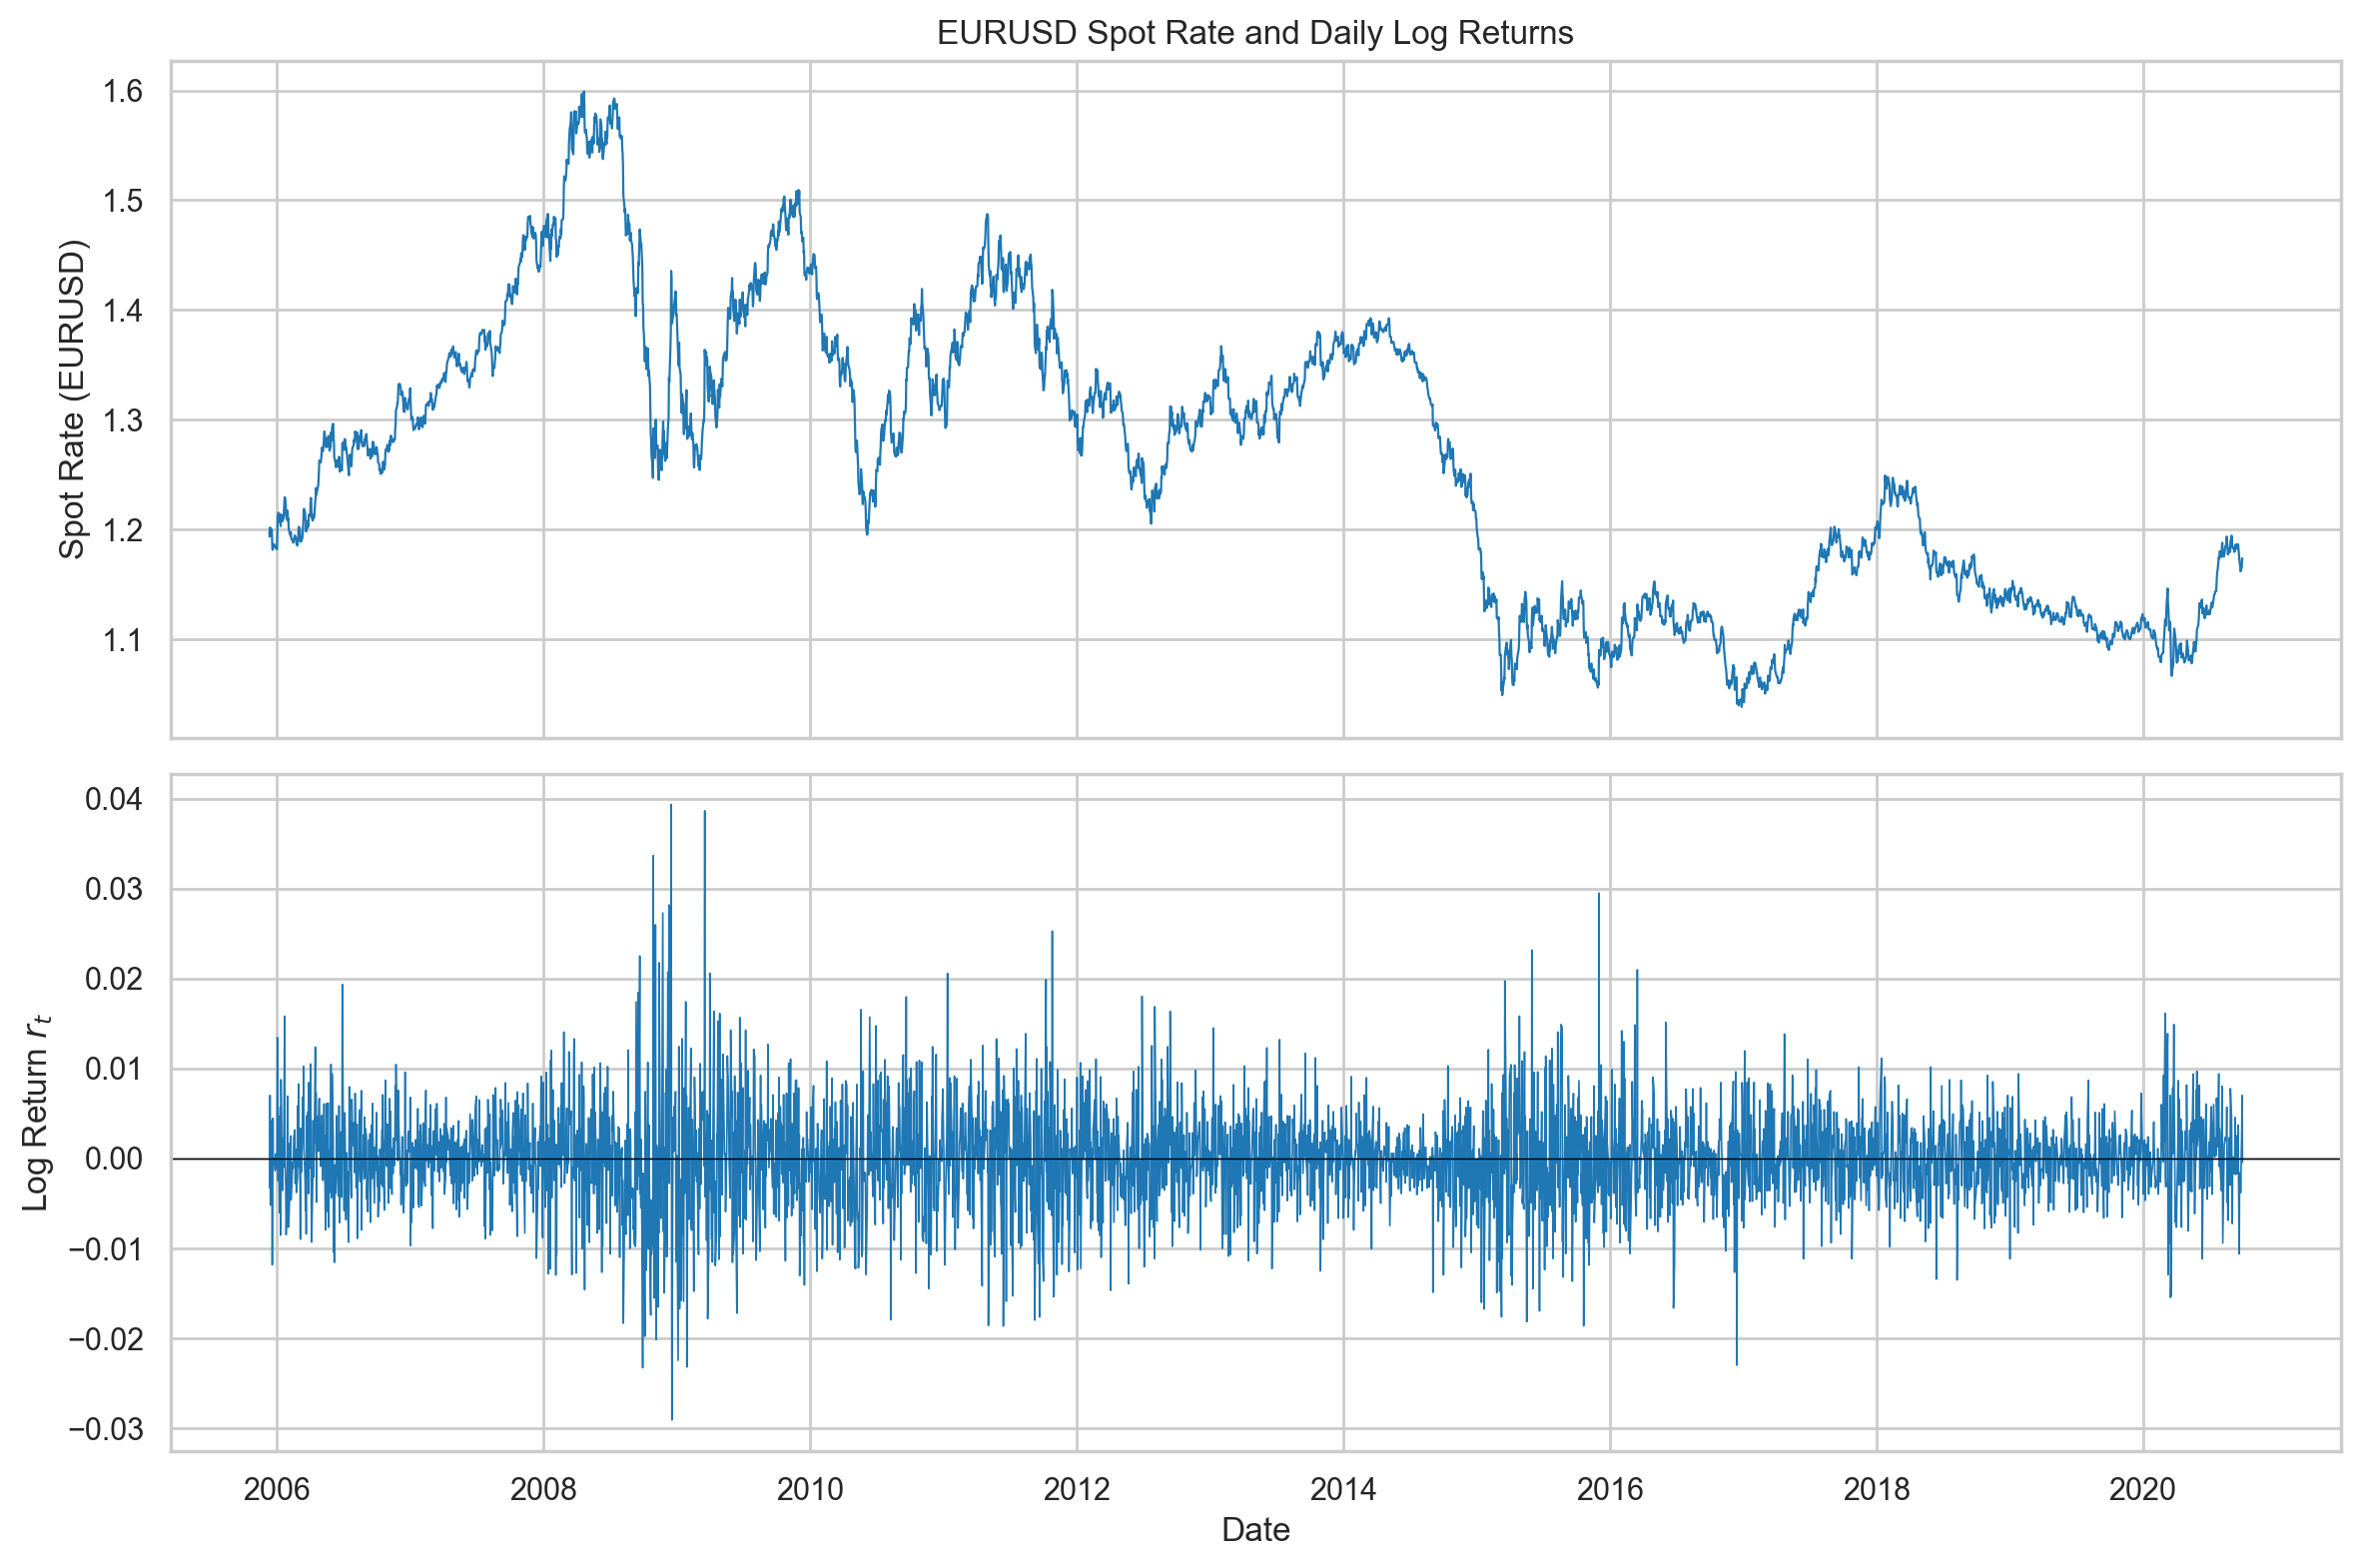

In [25]:
def log_return(spot):
    return np.log(spot).diff()

returns = log_return(data["Spot"])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(data.index, data["Spot"], color="#1F77B4", linewidth=0.8)
ax1.set_ylabel("Spot Rate (EURUSD)")
ax1.set_title("EURUSD Spot Rate and Daily Log Returns")

ax2.plot(returns.index, returns, color="#1F77B4", linewidth=0.6)
ax2.axhline(0, color="black", linewidth=0.5)
ax2.set_ylabel("Log Return $r_t$")
ax2.set_xlabel("Date")

fig.tight_layout()
plt.show()

### Stage 2: Risk Reversal First Difference

The raw risk reversal $RR_t$ captures the prevailing market skew. However, because skew levels can exhibit persistent trends unrelated to spot direction, it is the **change** in skew that carries directional information:

$$\Delta RR_t = RR_t - RR_{t-1}$$

A positive $\Delta RR_t$ indicates that upside optionality has become relatively more expensive — consistent with a bullish shift in market sentiment — while a negative value signals the reverse. First differencing also renders the series approximately stationary, improving the statistical properties of the downstream EWMA estimator.

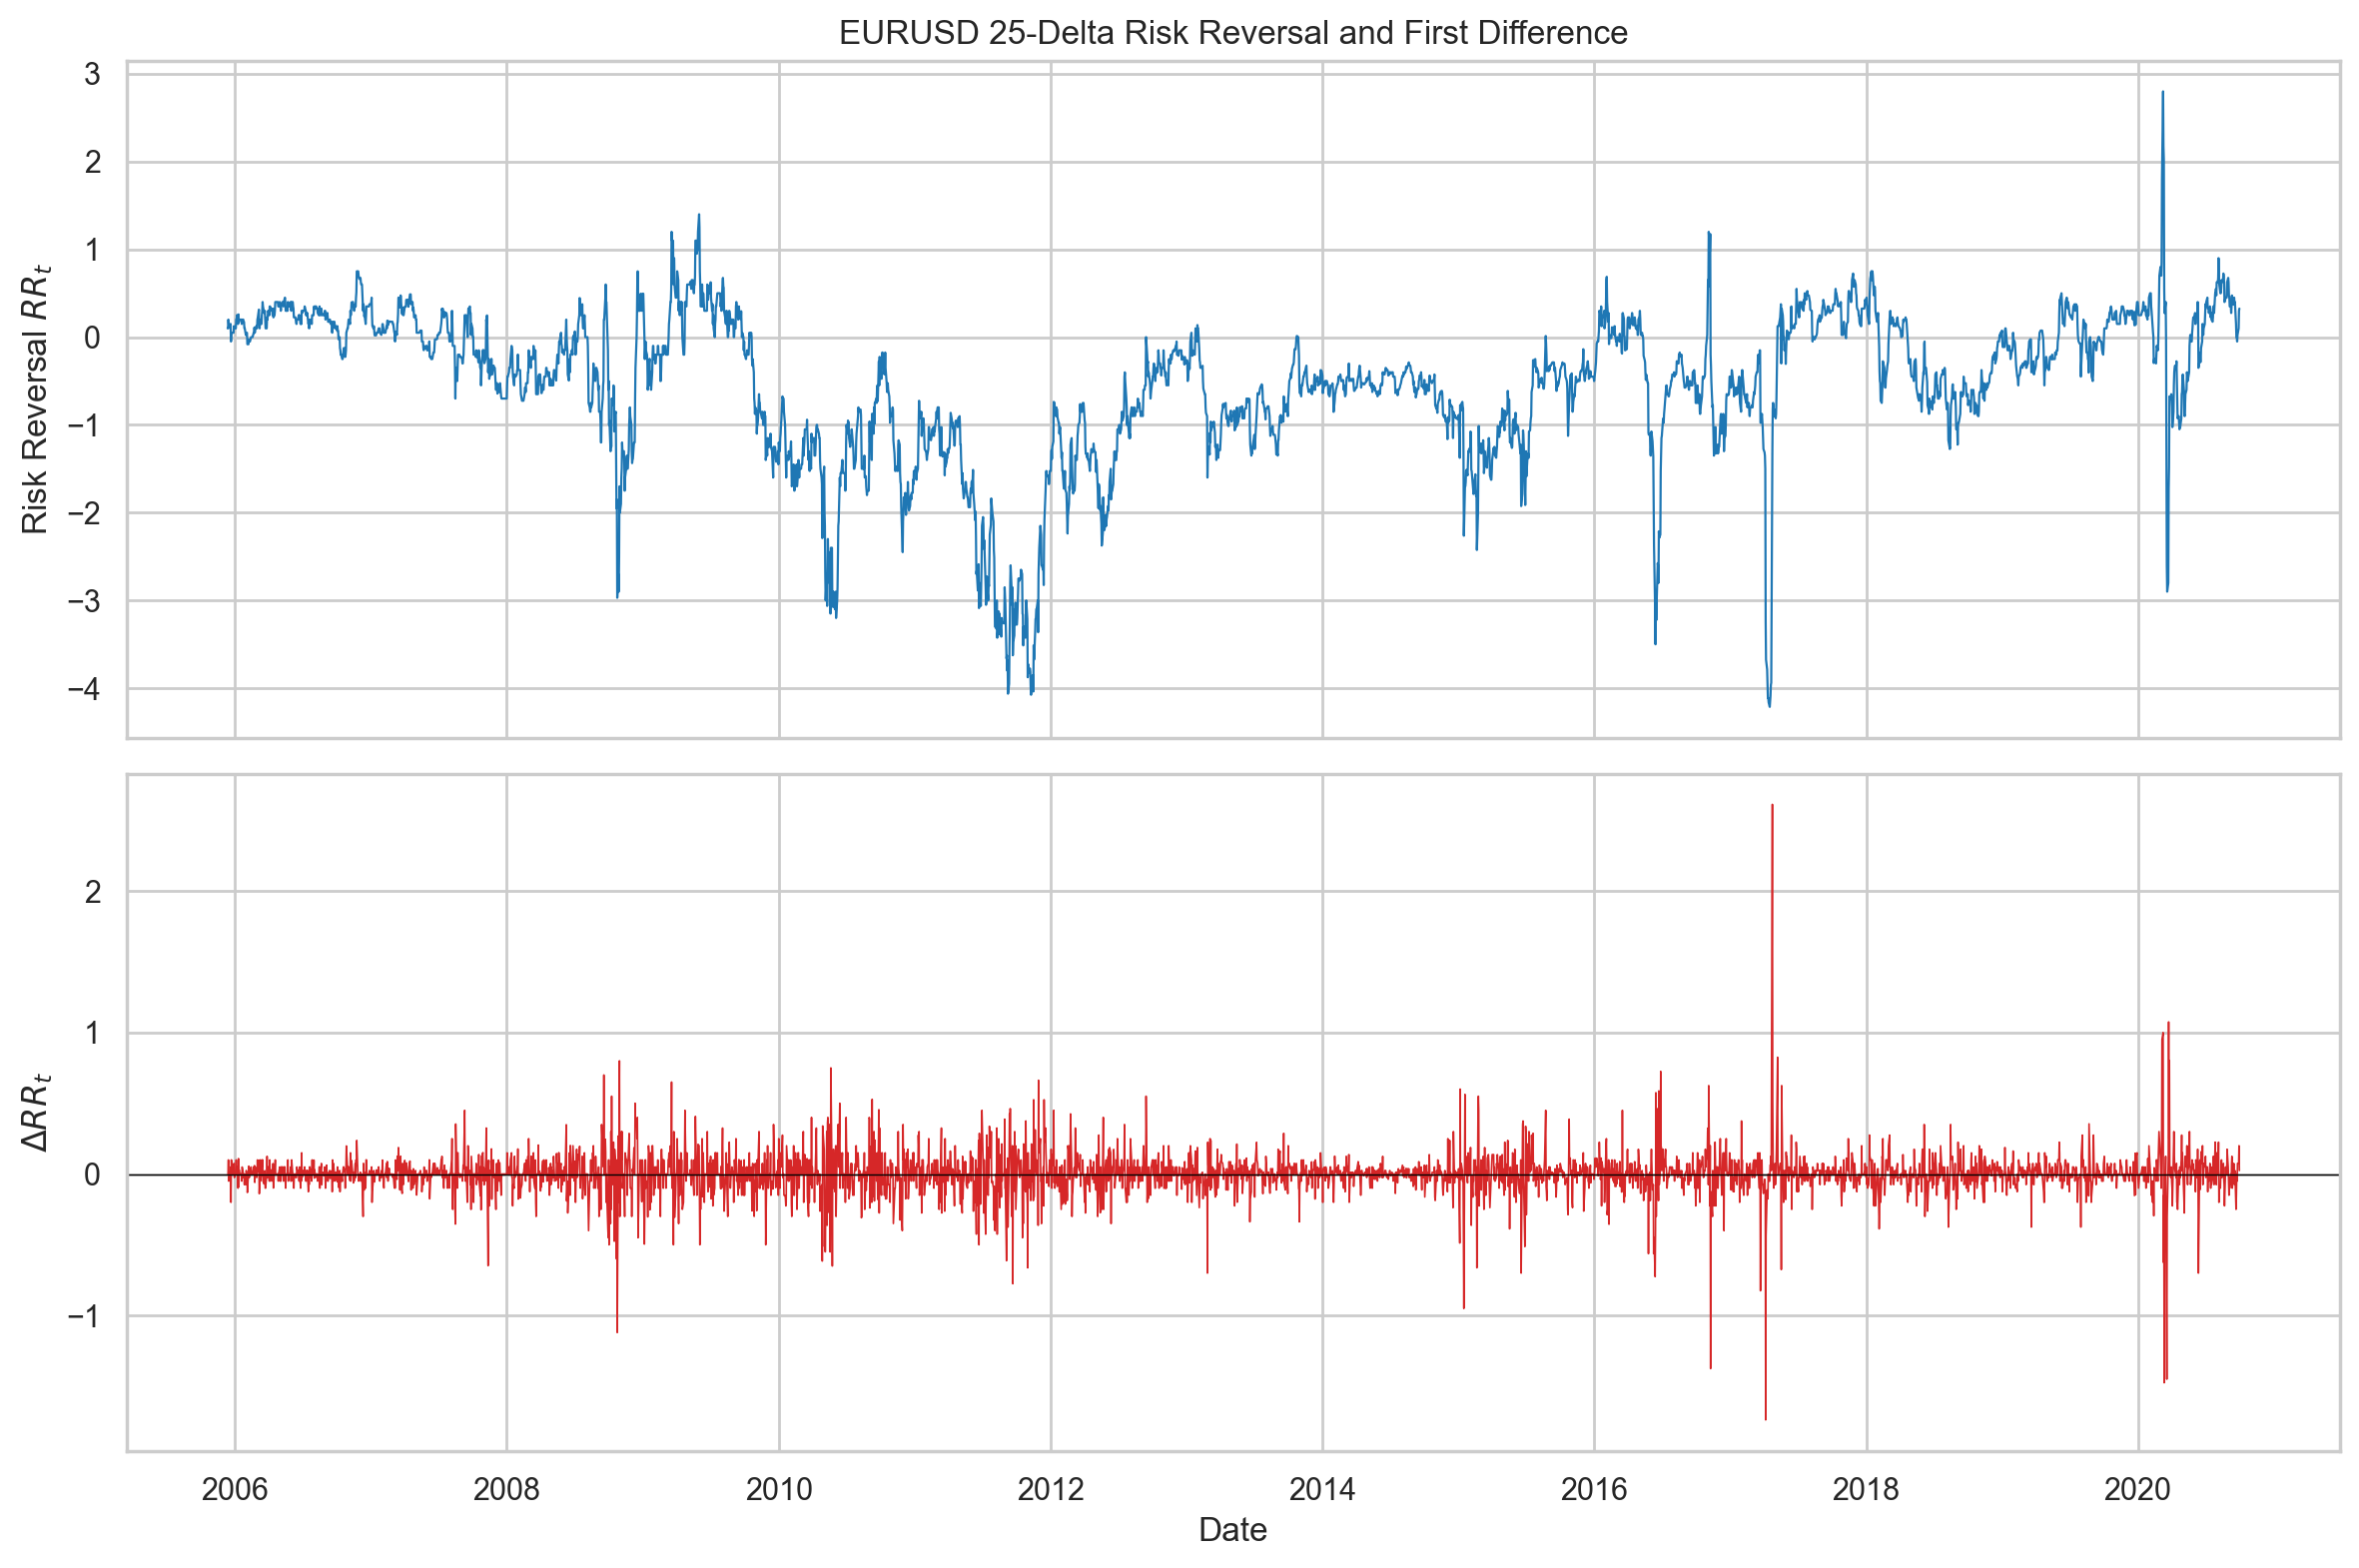

In [26]:
delta_rr = data["RiskRev"].diff()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(data.index, data["RiskRev"], color="#1F77B4", linewidth=0.8)
ax1.set_ylabel("Risk Reversal $RR_t$")
ax1.set_title("EURUSD 25-Delta Risk Reversal and First Difference")

ax2.plot(delta_rr.index, delta_rr, color="#D62728", linewidth=0.6)
ax2.axhline(0, color="black", linewidth=0.5)
ax2.set_ylabel(r"$\Delta RR_t$")
ax2.set_xlabel("Date")

fig.tight_layout()
plt.show()

### Stage 3: EWMA T-Statistic

To convert $\Delta RR_t$ into a standardised, scale-free signal, an exponentially weighted moving average (EWMA) t-statistic is constructed. With decay parameter $\lambda = 0.97$, the EWMA centre-of-mass is:

$$\text{com} = \frac{\lambda}{1 - \lambda} = \frac{0.97}{0.03} \approx 32.33$$

The effective window size — the number of periods representing 1.5 half-lives of the EWMA — is:

$$W = \text{round}\!\left(1.5 \cdot \frac{1 + \lambda}{1 - \lambda}\right) = \text{round}(98.5) = 98$$

The EWMA mean and second moment of $\Delta RR_t$ are:

$$\hat{\beta}_t = \text{EWMA}(\Delta RR_t;\, \text{com})$$

$$\hat{\gamma}_t = \text{EWMA}(\Delta RR_t^2;\, \text{com})$$

The EWMA standard error is then:

$$\widehat{SE}_t = \sqrt{\frac{\hat{\gamma}_t - \hat{\beta}_t^2}{W - 1}}$$

And the t-statistic is:

$$e_t = \frac{\hat{\beta}_t}{\widehat{SE}_t}$$

This statistic measures how many standard errors the EWMA mean lies from zero, providing a volatility-adjusted measure of directional skew momentum.

In [27]:
def tstat_deltaRR(RR, decay=0.97):
    com = decay / (1 - decay)
    window_size = round(1.5 * (1 + decay) / (1 - decay))
    print(f"\u03bb = {decay}  |  com = {com:.4f}  |  W = {window_size}")

    deltaRR = RR.diff()
    deltaRR_sqr = deltaRR ** 2

    beta  = deltaRR.ewm(com=com, adjust=False).mean()
    gamma = deltaRR_sqr.ewm(com=com, adjust=False).mean()

    std_err = np.sqrt((gamma - beta ** 2) / (window_size - 1))
    t_stat  = beta / std_err

    return t_stat

raw_tstat = tstat_deltaRR(data["RiskRev"])
raw_tstat.tail()

λ = 0.97  |  com = 32.3333  |  W = 98


date
2020-09-24   -0.902638
2020-09-25   -0.706277
2020-09-28   -0.512920
2020-09-29   -0.022166
2020-09-30    0.036955
Name: RiskRev, dtype: float64

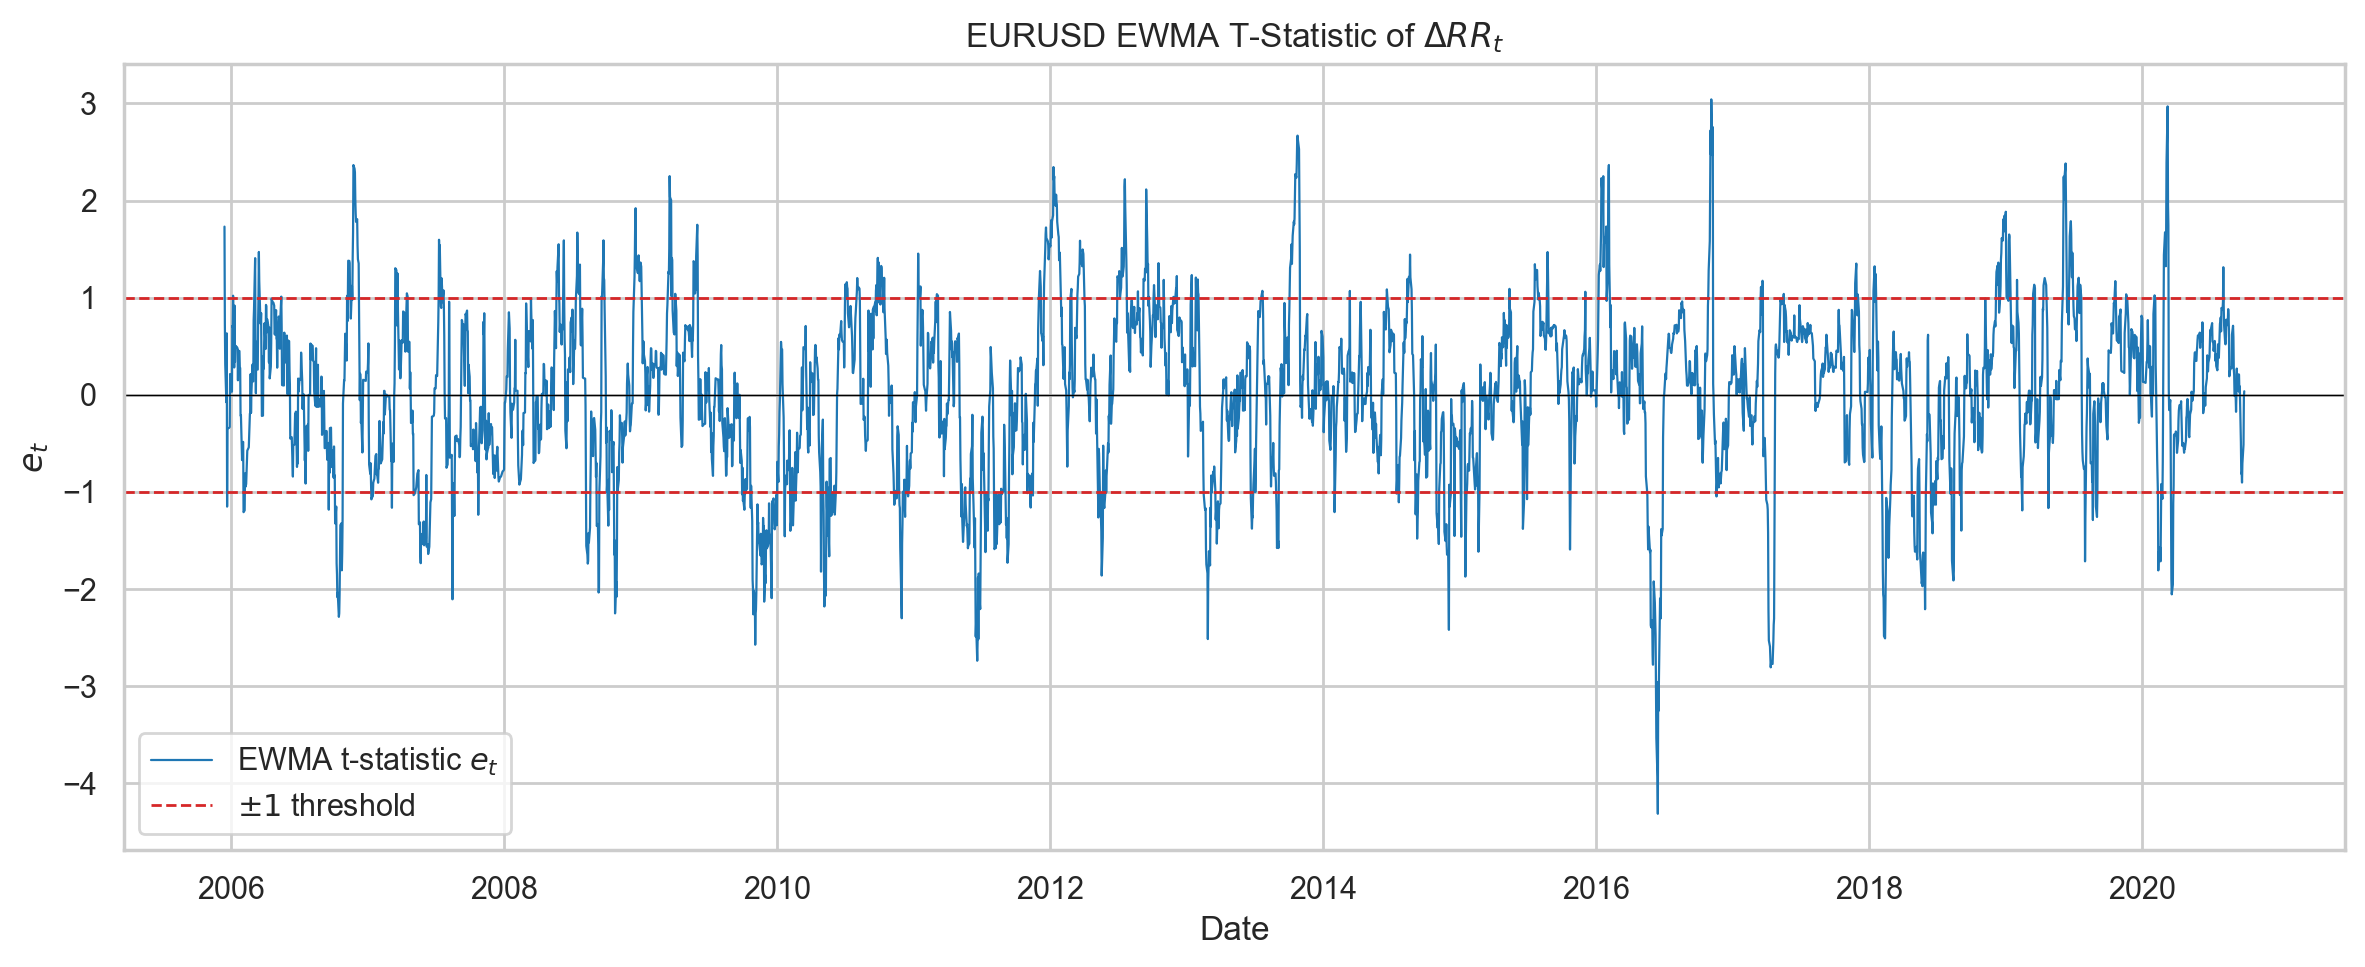

In [28]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(raw_tstat.index, raw_tstat, color="#1F77B4", linewidth=0.8,
        label="EWMA t-statistic $e_t$")
ax.axhline(0,  color="black",   linewidth=0.5)
ax.axhline(+1, color="#D62728", linestyle="--", linewidth=1.0, label="$\\pm 1$ threshold")
ax.axhline(-1, color="#D62728", linestyle="--", linewidth=1.0)

ax.set_ylabel("$e_t$")
ax.set_xlabel("Date")
ax.set_title("EURUSD EWMA T-Statistic of $\\Delta RR_t$")
ax.legend()

plt.tight_layout()
plt.show()

### Stage 4: Smoothing Function

The raw t-statistic $e_t$ is mapped to a bounded position signal $f(e_t) \in [-1, +1]$ via a piecewise smoothing function:

$$f(e) = \begin{cases} \sin\!\left(\dfrac{e\,\pi}{2}\right) & \text{if } |e| \le 1 \\\\ \text{sign}(e) & \text{if } |e| > 1 \end{cases}$$

Key properties:

- **Bounded:** $f(e) \in [-1, +1]$ for all $e$, capping position size at full long or short.
- **Smooth at the origin:** $f'(0) = \pi/2$, providing maximum sensitivity to weak signals.
- **Saturation:** for $|e| > 1$ the signal is fully committed; confidence beyond one standard error does not alter position size.
- **Odd symmetry:** $f(-e) = -f(e)$, ensuring symmetric treatment of bullish and bearish signals.

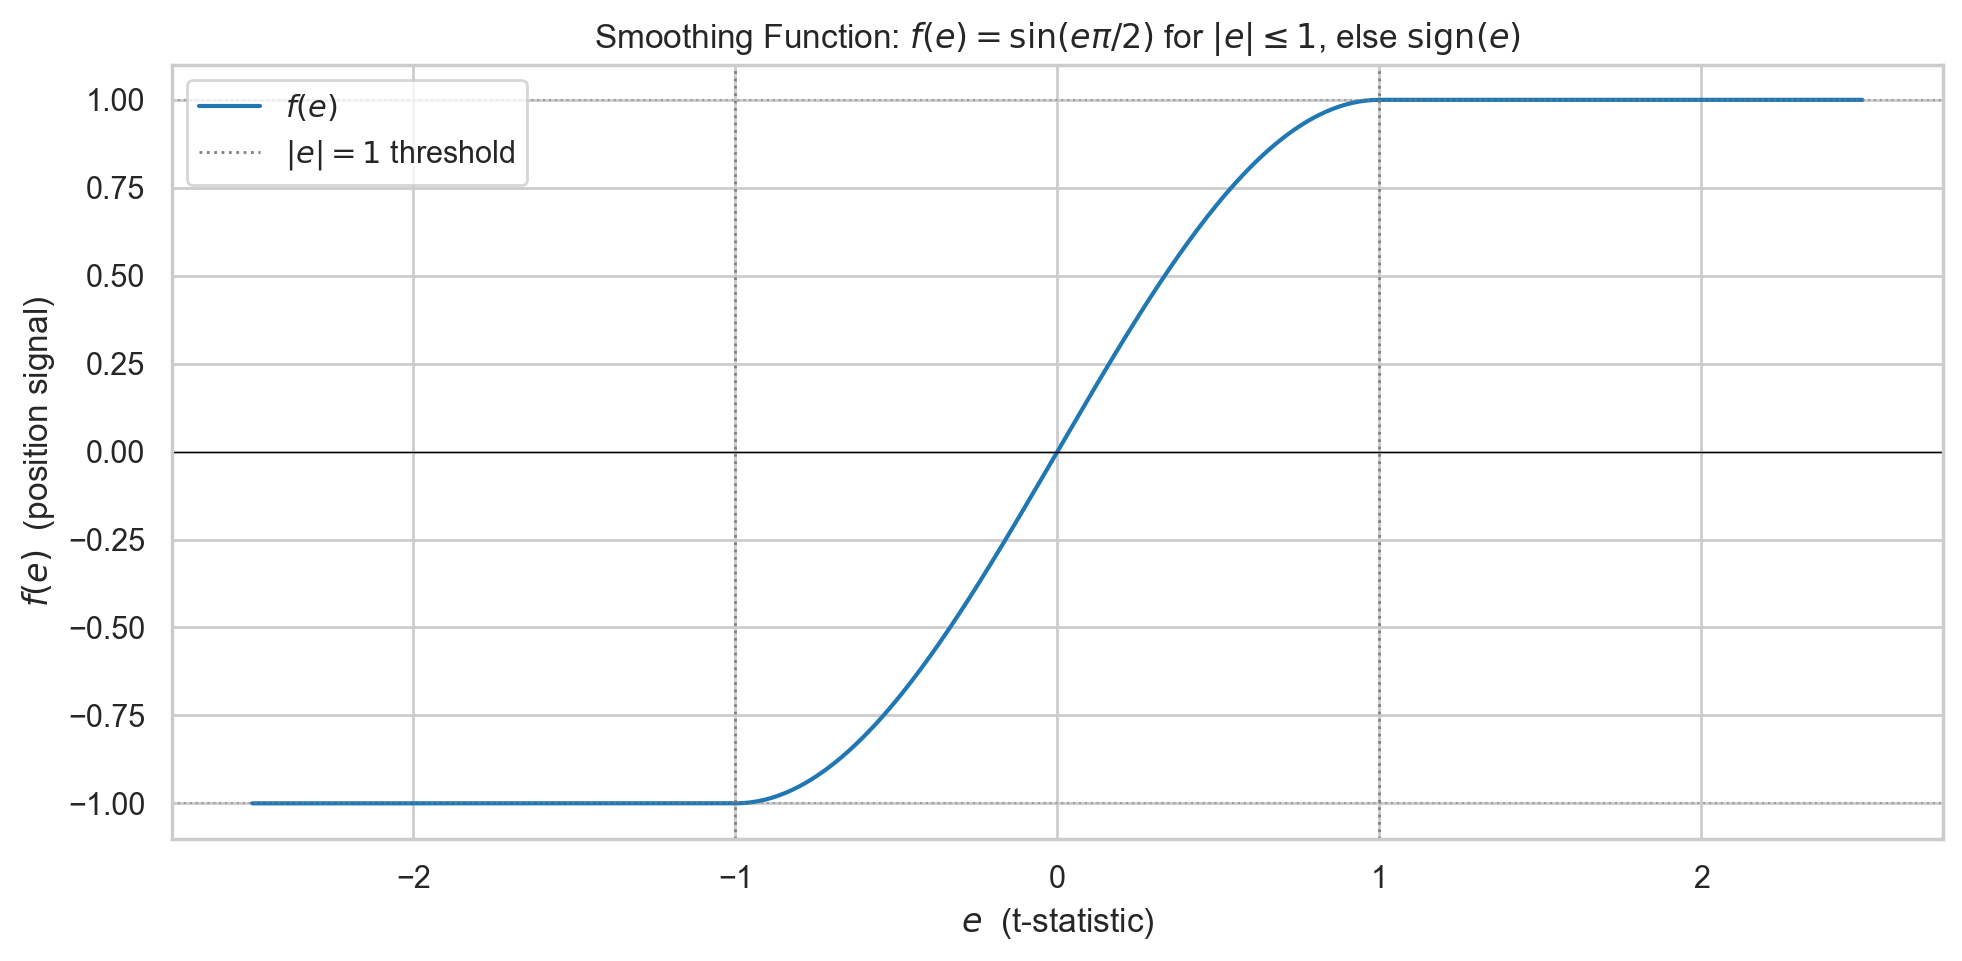

In [29]:
e_vals = np.linspace(-2.5, 2.5, 500)

def smoothing_fn(e):
    return np.where(np.abs(e) <= 1, np.sin(e * np.pi / 2), np.sign(e))

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(e_vals, smoothing_fn(e_vals), color="#1F77B4", linewidth=1.5, label="$f(e)$")
ax.axhline(0,  color="black", linewidth=0.5)
ax.axhline(+1, color="grey",  linestyle=":", linewidth=0.8, alpha=0.6)
ax.axhline(-1, color="grey",  linestyle=":", linewidth=0.8, alpha=0.6)
ax.axvline(-1, color="grey",  linestyle=":", linewidth=1.0, label="$|e| = 1$ threshold")
ax.axvline(+1, color="grey",  linestyle=":", linewidth=1.0)

ax.set_xlabel("$e$  (t-statistic)")
ax.set_ylabel("$f(e)$  (position signal)")
ax.set_title(r"Smoothing Function: $f(e) = \sin(e\pi/2)$ for $|e| \leq 1$, else $\mathrm{sign}(e)$")
ax.legend()

plt.tight_layout()
plt.show()

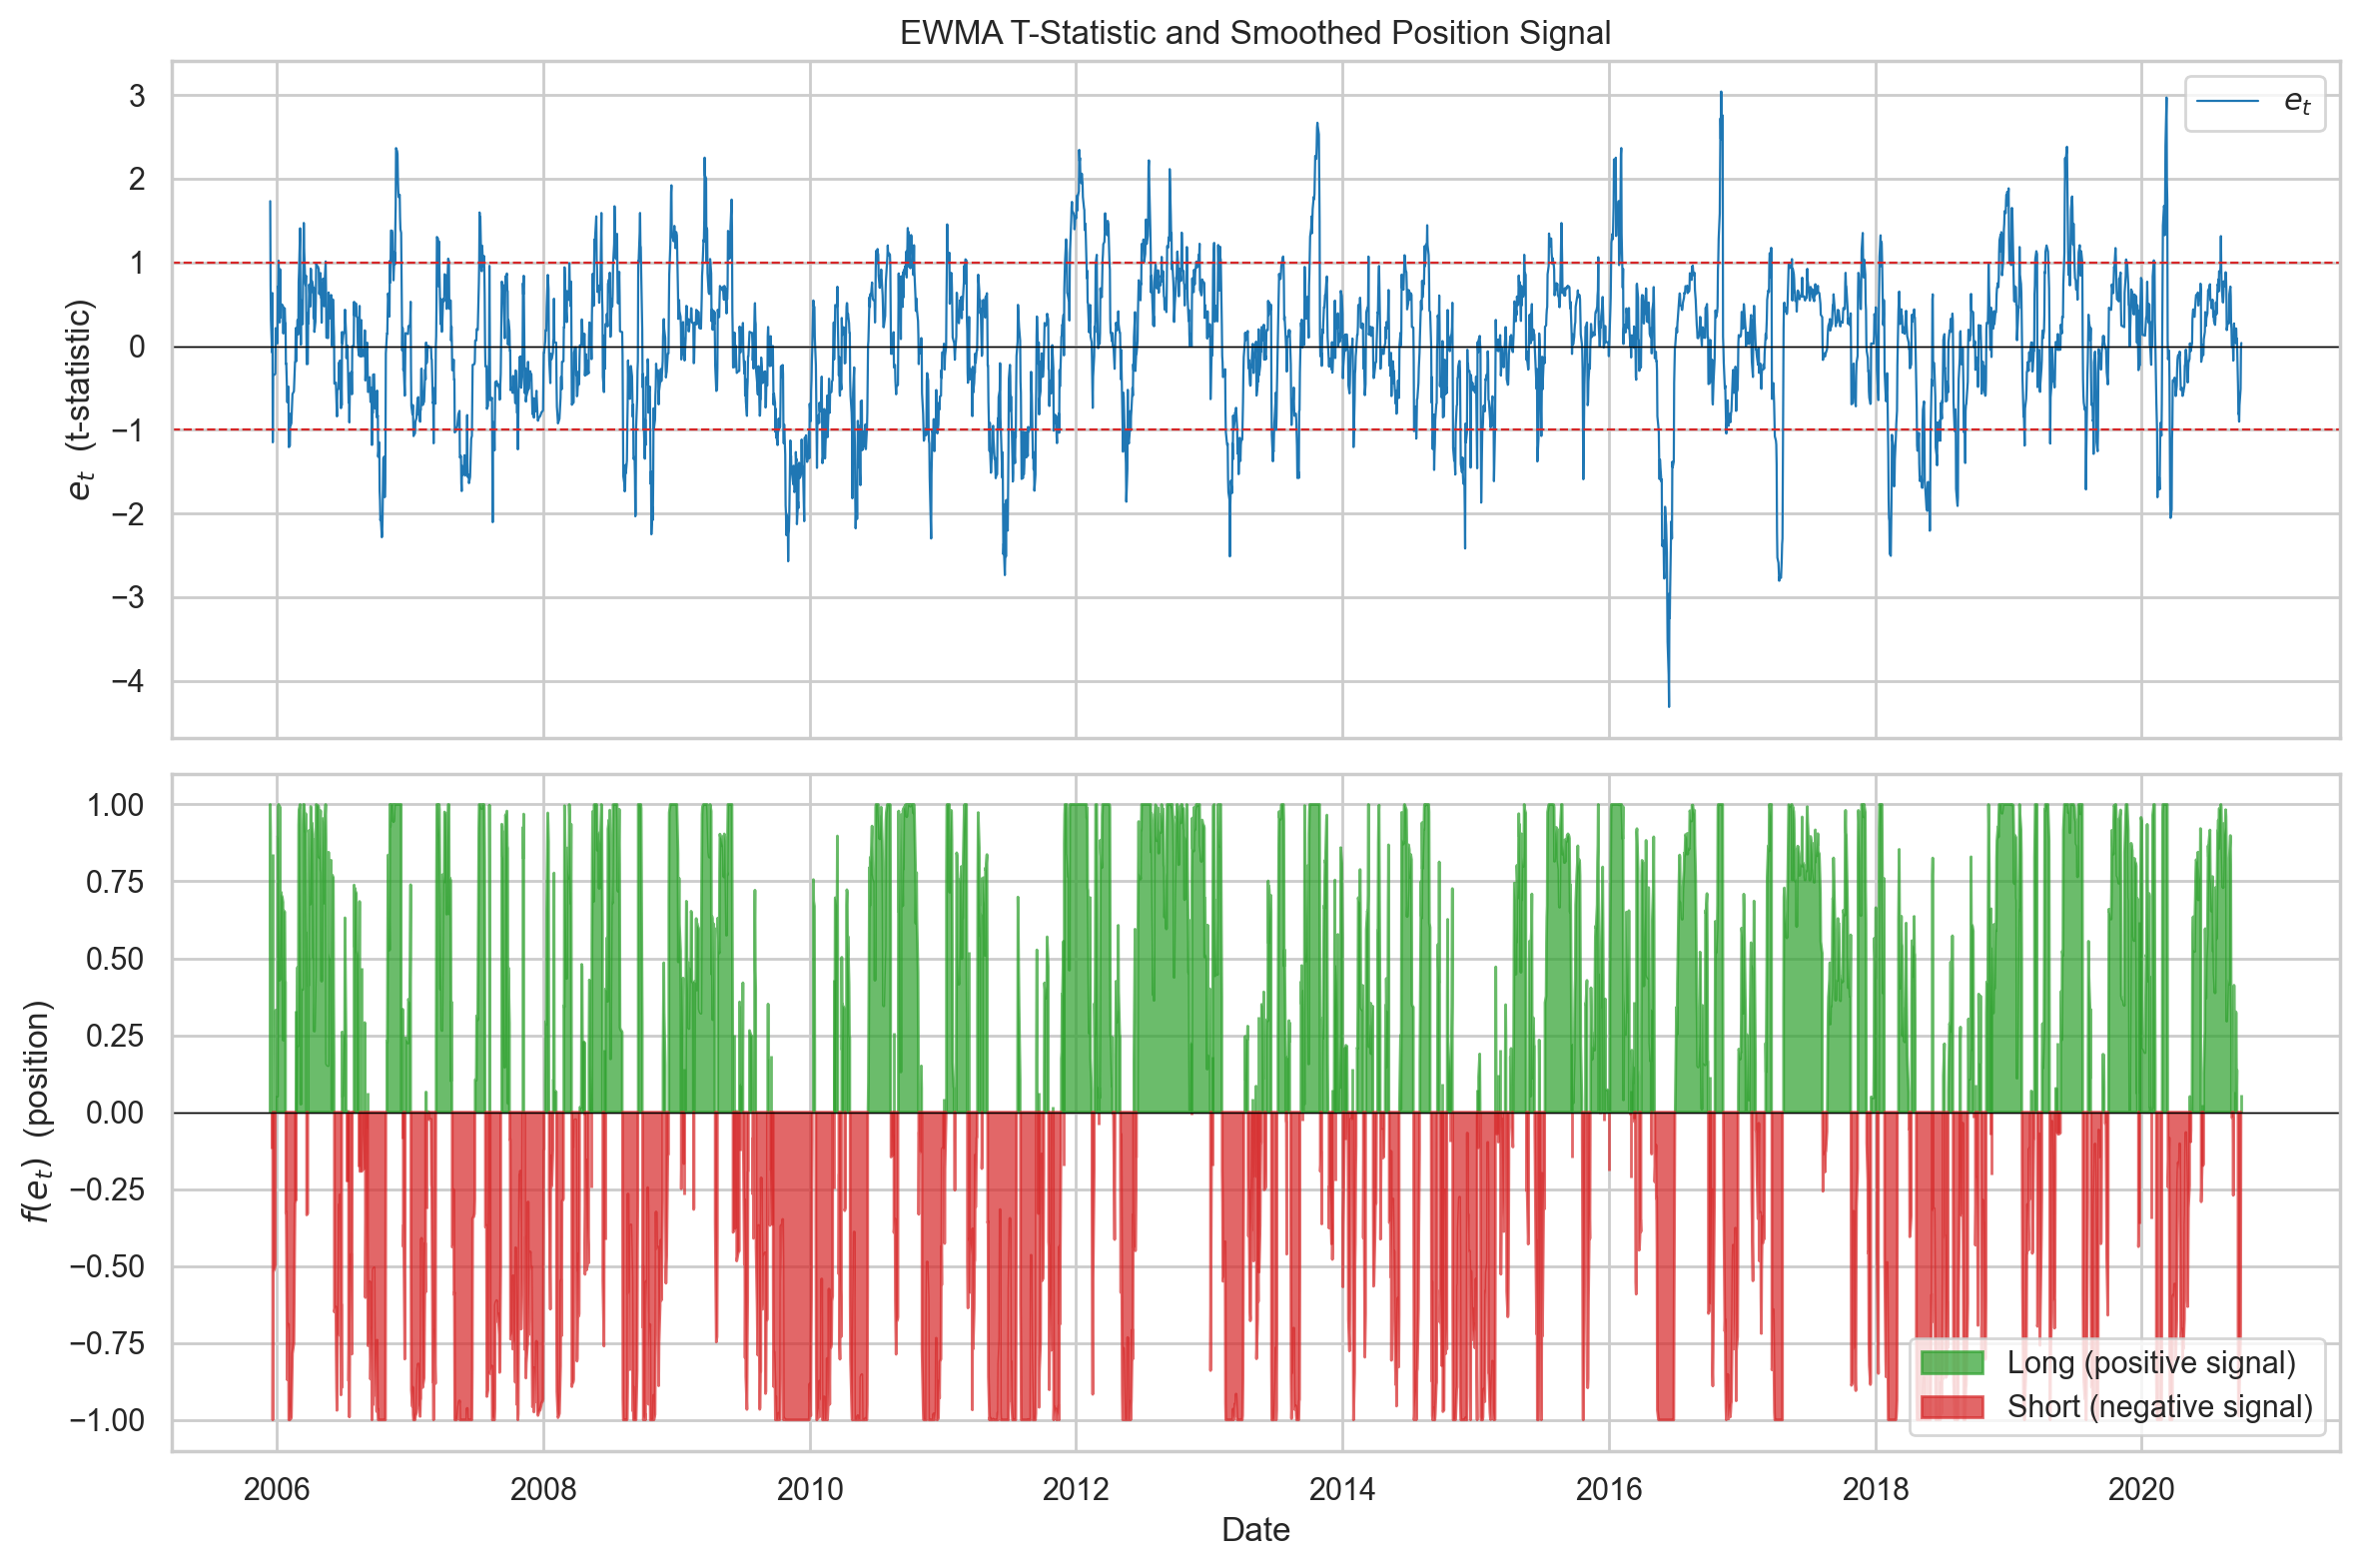

In [30]:
smoothed_signal = raw_tstat.apply(
    lambda e: np.sin(e * np.pi / 2) if abs(e) <= 1 else np.sign(e)
)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(raw_tstat.index, raw_tstat, color="#1F77B4", linewidth=0.8, label="$e_t$")
ax1.axhline(0,  color="black",   linewidth=0.5)
ax1.axhline(+1, color="#D62728", linestyle="--", linewidth=0.8)
ax1.axhline(-1, color="#D62728", linestyle="--", linewidth=0.8)
ax1.set_ylabel("$e_t$  (t-statistic)")
ax1.set_title("EWMA T-Statistic and Smoothed Position Signal")
ax1.legend()

ax2.fill_between(
    smoothed_signal.index, smoothed_signal, 0,
    where=(smoothed_signal >= 0),
    color="#2CA02C", alpha=0.7, label="Long (positive signal)"
)
ax2.fill_between(
    smoothed_signal.index, smoothed_signal, 0,
    where=(smoothed_signal < 0),
    color="#D62728", alpha=0.7, label="Short (negative signal)"
)
ax2.axhline(0, color="black", linewidth=0.5)
ax2.set_ylabel("$f(e_t)$  (position)")
ax2.set_xlabel("Date")
ax2.legend()

fig.tight_layout()
plt.show()

### P&L Construction

The daily strategy return is the product of the previous day's position signal and the current day's log return:

$$\text{PnL}_t = f(e_{t-1}) \times r_t$$

The one-period lag on the position — $f(e_{t-1})$ rather than $f(e_t)$ — is essential: the signal is observed at the **close of day $t-1$** and the trade is executed at the **open of day $t$**, ensuring no look-ahead bias. The cumulative P&L is $\sum_{t} \text{PnL}_t$ in log-return space, equivalent to the product of gross returns in levels.

Annualised return : 0.0407  (4.07%)
Annualised vol    : 0.0661  (6.61%)
Sharpe ratio      : 0.6159


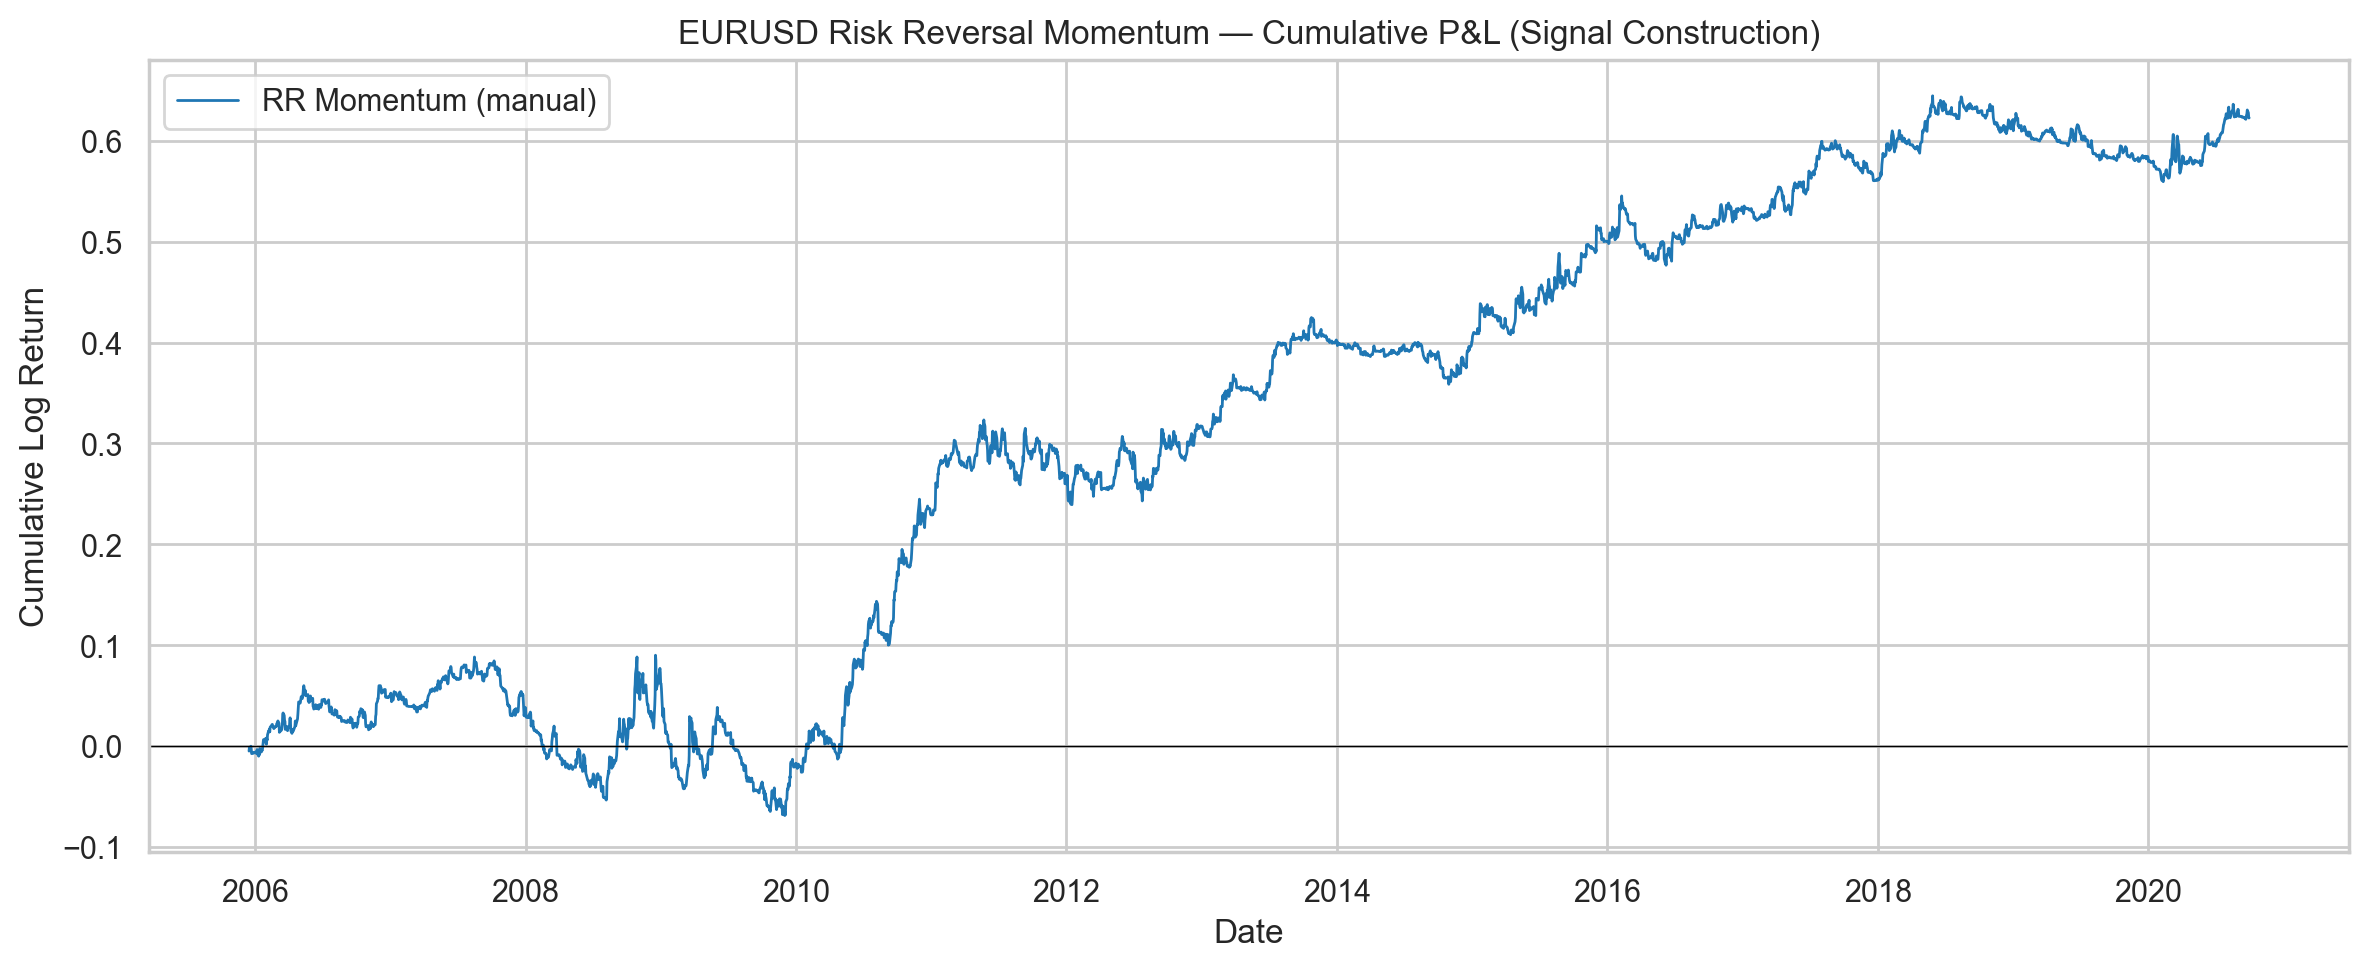

In [31]:
position = smoothed_signal.shift(1)
pnl      = (position * returns).dropna()

ann_return = pnl.mean() * 252
ann_vol    = pnl.std()  * np.sqrt(252)
sharpe     = ann_return / ann_vol

print(f"Annualised return : {ann_return:.4f}  ({ann_return * 100:.2f}%)")
print(f"Annualised vol    : {ann_vol:.4f}  ({ann_vol * 100:.2f}%)")
print(f"Sharpe ratio      : {sharpe:.4f}")

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(pnl.cumsum().index, pnl.cumsum().values,
        color="#1F77B4", linewidth=1.0, label="RR Momentum (manual)")
ax.axhline(0, color="black", linewidth=0.5)
ax.set_ylabel("Cumulative Log Return")
ax.set_xlabel("Date")
ax.set_title("EURUSD Risk Reversal Momentum — Cumulative P&L (Signal Construction)")
ax.legend()

plt.tight_layout()
plt.show()

## 3. EURUSD Strategy: Class-Based Analysis

The `RiskReversalMomentum` class encapsulates the full four-stage pipeline — data loading, signal construction, and performance accounting — in a single reusable object. The constructor signature is:

```python
RiskReversalMomentum(symbol, start, end, amount, data_folder="../data/", tc=0)
```

| Argument | Type | Description |
|----------|------|-------------|
| `symbol` | `str` | Currency pair identifier (e.g. `"EURUSD"`) |
| `start` | `str` | Start date in `"MM-DD-YYYY"` format |
| `end` | `str` | End date in `"MM-DD-YYYY"` format |
| `amount` | `float` | Notional in base currency units |
| `data_folder` | `str` | Path to the directory containing market data CSVs |
| `tc` | `float` | Proportional transaction cost per trade (default `0`) |

Calling `run_strategy()` populates `rrm.results` with four columns: `return` (daily log return), `position` (smoothed signal $f(e_t)$), `strategy` (signal-weighted daily return), `creturns` (buy-and-hold cumulative value), and `cstrategy` (strategy cumulative value).

In [32]:
rrm = RiskReversalMomentum(
    "EURUSD", "12-12-2005", "03-24-2020",
    amount=1_000_000,
    data_folder="../../data/"
)
rrm.run_strategy()
rrm.results.tail()

,Spot,ImpVol,RiskRev,Bfly,IR_X,IR_Y,return,position,strategy,creturns,cstrategy
date,,,,,,,,,,,
2020-09-24,1.1663,0.0675,-0.050,0.1750,-0.5207,0.14475,-0.001542,-0.988328,0.001466,974027.058627,1.871842e+06
2020-09-25,1.1619,0.0660,0.025,0.1875,-0.5461,0.14613,-0.003780,-0.895440,0.003736,970352.430266,1.878848e+06
2020-09-28,1.1656,0.0655,0.100,0.1875,-0.5515,0.14663,0.003179,-0.721311,-0.002847,973442.458660,1.873507e+06
2020-09-29,1.1738,0.0665,0.300,0.2000,-0.5193,0.14663,0.007010,-0.034812,-0.005057,980290.629698,1.864057e+06
2020-09-30,1.1733,0.0670,0.325,0.2000,-0.5175,0.14663,-0.000426,0.058016,0.000015,979873.058293,1.864085e+06


### Performance Series

`rrm.results` contains two cumulative P&L series, both expressed in notional currency units:

- **`creturns`** — buy-and-hold performance: $\text{amount} \times \exp\!\left(\sum_t r_t\right)$. Represents a passive long position in the currency pair throughout the sample.
- **`cstrategy`** — signal-weighted performance: $\text{amount} \times \exp\!\left(\sum_t f(e_{t-1}) \cdot r_t\right)$. The strategy goes long when the smoothed t-statistic is positive and short when it is negative, dynamically sizing the position within $[-1, +1]$.

The difference between the two series isolates the value added by the risk reversal signal over a passive carry position.

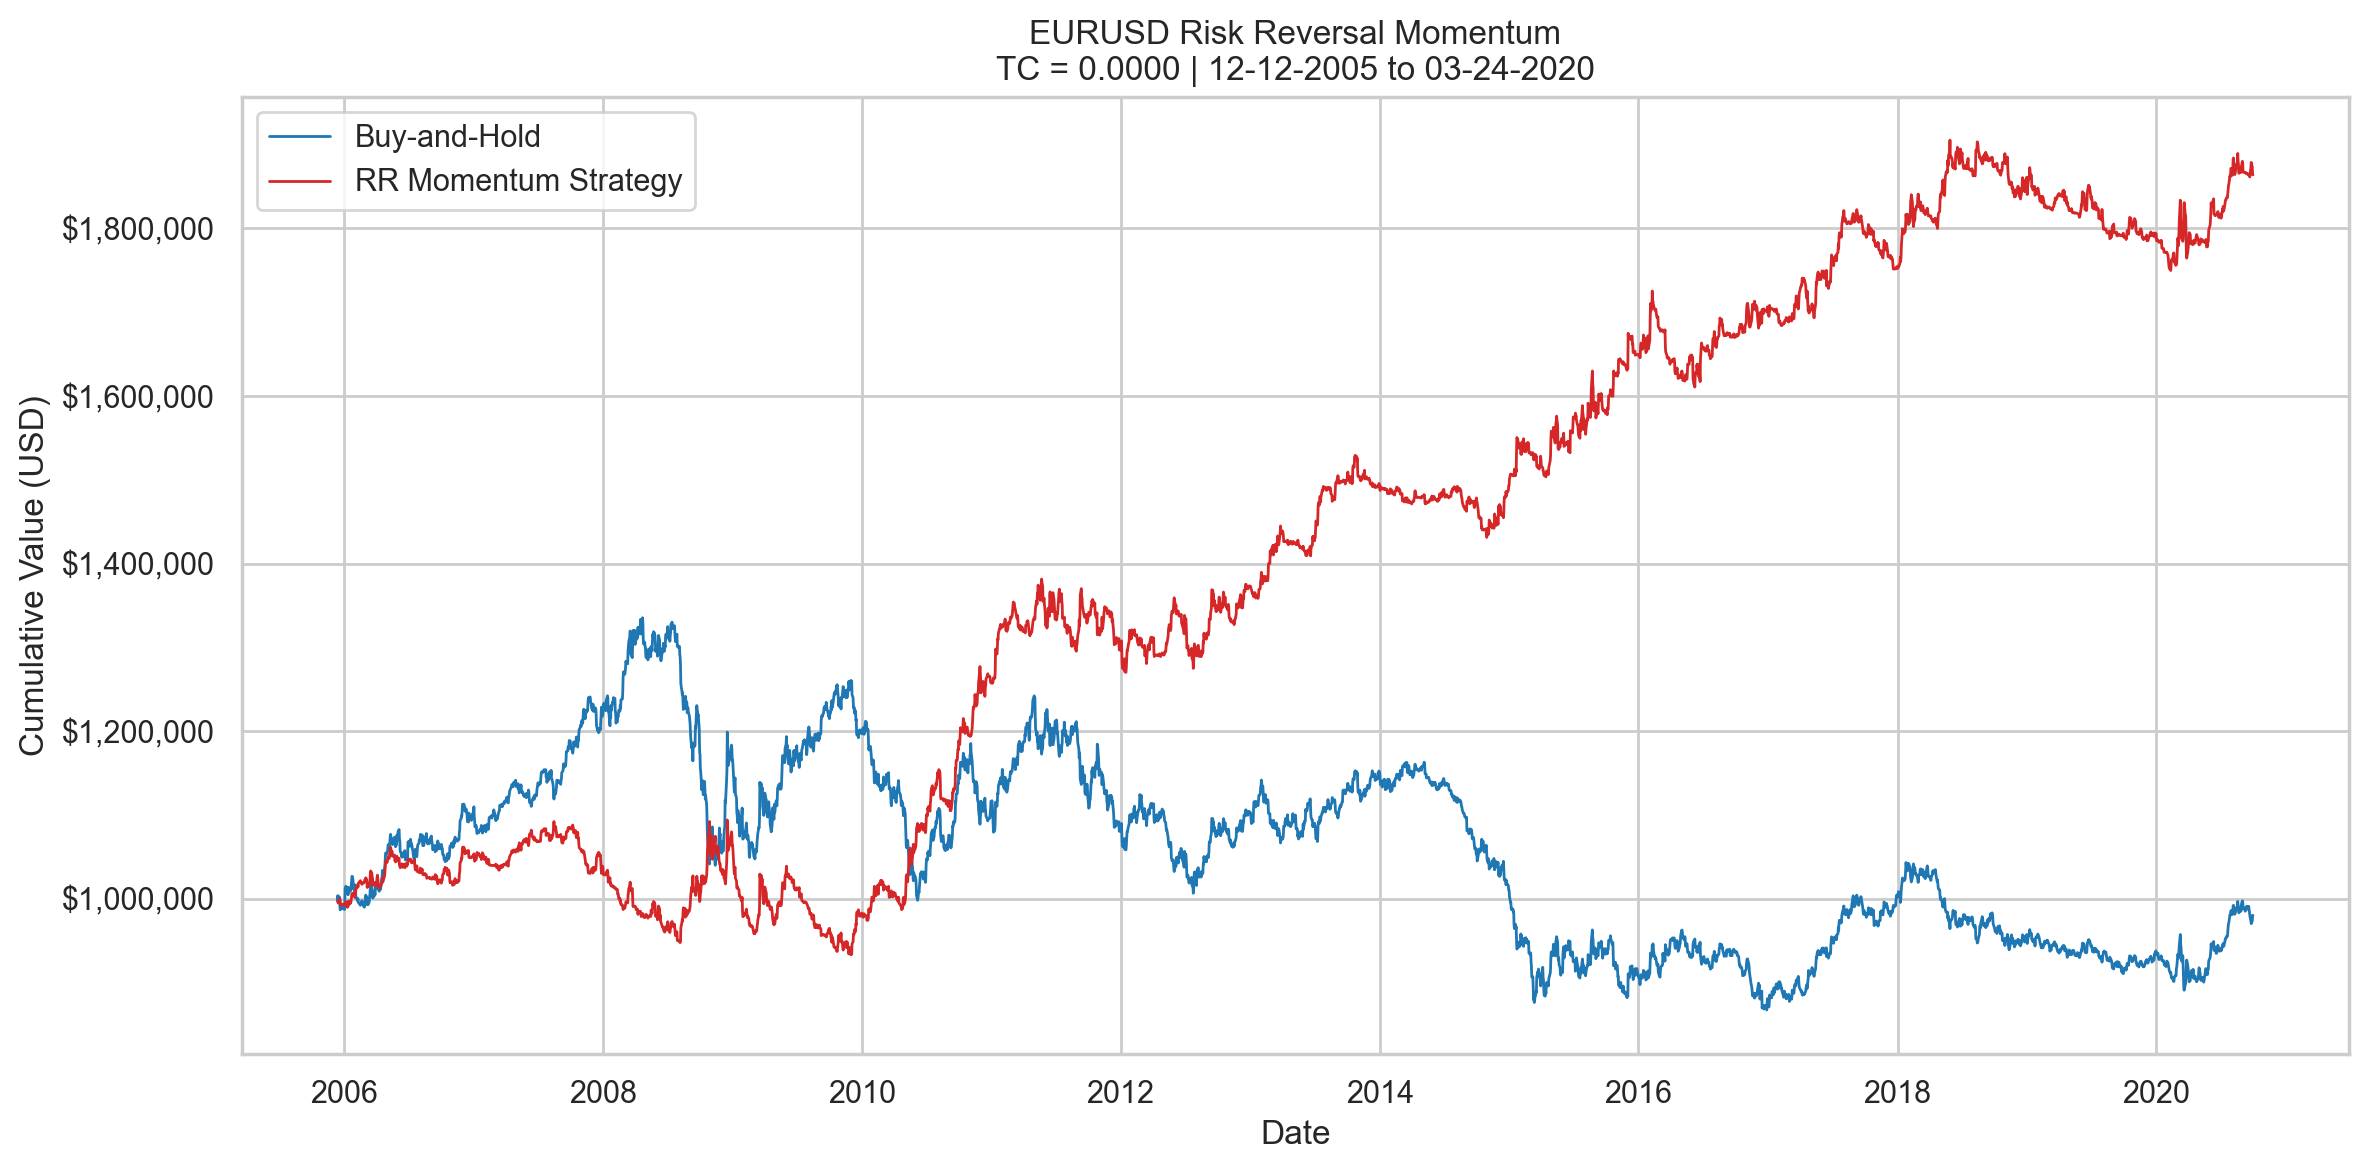

In [33]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(rrm.results.index, rrm.results["creturns"],
        color="#1F77B4", linewidth=1.0, label="Buy-and-Hold")
ax.plot(rrm.results.index, rrm.results["cstrategy"],
        color="#D62728", linewidth=1.0, label="RR Momentum Strategy")

ax.yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda x, _: f"${x:,.0f}")
)
ax.set_title(
    f"EURUSD Risk Reversal Momentum\nTC = {rrm.tc:.4f} | {rrm.start} to {rrm.end}"
)
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Value (USD)")
ax.legend()

plt.tight_layout()
plt.show()

In [34]:
def summary_stats(returns_series, label):
    ann_ret = returns_series.mean() * 252
    ann_vol = returns_series.std()  * np.sqrt(252)
    sharpe  = ann_ret / ann_vol
    cum     = returns_series.cumsum()
    drawdown = cum - cum.cummax()
    max_dd  = drawdown.min()
    return {
        "Label":               label,
        "Annualised Return":   f"{ann_ret * 100:.2f}%",
        "Annualised Vol":      f"{ann_vol * 100:.2f}%",
        "Sharpe Ratio":        f"{sharpe:.4f}",
        "Max Drawdown":        f"{max_dd * 100:.2f}%",
    }

res = rrm.results.dropna()
stats = pd.DataFrame([
    summary_stats(res["return"],   "Buy-and-Hold"),
    summary_stats(res["strategy"], "RR Momentum Strategy"),
]).set_index("Label")

stats

,Annualised Return,Annualised Vol,Sharpe Ratio,Max Drawdown
Label,,,,
Buy-and-Hold,-0.16%,8.87%,-0.0177,-43.17%
RR Momentum Strategy,4.07%,6.61%,0.6159,-15.90%


### Analytical Interpretation

The strategy generates its most pronounced outperformance during periods of sustained macro dislocation, where risk reversal skew shifts are large, persistent, and directionally coherent with subsequent spot moves:

- **2008 Global Financial Crisis (Sep 2008 – Mar 2009):** EUR/USD risk reversals repriced sharply in favour of USD puts as deleveraging accelerated. The strategy's short signal captured the EUR decline, while the buy-and-hold position suffered significant drawdown.
- **2011–2012 Euro Sovereign Debt Crisis:** Persistent negative risk reversal shifts — reflecting demand for EUR downside protection — generated extended short signals aligned with EUR weakness against the USD.
- **2020 COVID Risk-Off (Mar 2020):** The sample end-date (24 March 2020) captures the initial risk-off shock. Risk reversals repriced sharply; the strategy's response speed depended on the EWMA lag (~98 days effective window), limiting full capture of rapid regime changes.

### Limitations

| Limitation | Impact |
|------------|--------|
| **Zero transaction costs** (`tc=0`) | Overstates net returns; real-money implementation would incur bid-offer spread and market impact |
| **EWMA lag (~98 effective days)** | Signal is slow to respond to sharp regime changes; early-stage moves may be missed |
| **No volatility targeting** | Position sizing is bounded to $[-1, +1]$ but not scaled to a target realised volatility; cross-period Sharpe comparisons are affected by volatility regime changes |
| **Single-factor signal** | The strategy relies exclusively on $\Delta RR_t$; orthogonal signals (carry, momentum, positioning) are ignored |

## 4. Multi-Currency Analysis

The signal construction pipeline is applied to all four available G10 currency pairs: **EURUSD**, **GBPUSD**, **EURCHF**, and **USDCHF**. All datasets share the same column schema and start date (December 2005), permitting a consistent cross-sectional comparison.

Two structural differences merit attention before interpreting the results:

- **Risk reversal sign conventions differ by pair.** A positive EURUSD risk reversal denotes demand for EUR upside; a positive USDCHF risk reversal denotes demand for USD upside. The signal is applied symmetrically in all cases — the strategy takes a long position when $f(e_t) > 0$ regardless of which leg of the pair is the base currency.
- **CHF pairs carry safe-haven dynamics.** EURCHF and USDCHF risk reversals are heavily influenced by flight-to-quality flows rather than pure directional carry, making their skew signals qualitatively different from the EUR and GBP pairs.

In [35]:
PAIRS = ["EURUSD", "GBPUSD", "EURCHF", "USDCHF"]
COLOURS = ["#1F77B4", "#D62728", "#2CA02C", "#FF7F0E"]

strategies = {}

for sym in PAIRS:
    rrm_ = RiskReversalMomentum(
        sym, "12-12-2005", "03-24-2020",
        amount=1_000_000,
        data_folder="../../data/"
    )
    rrm_.run_strategy()
    strategies[sym] = rrm_

    res     = rrm_.results.dropna()
    ann_ret = res["strategy"].mean() * 252
    ann_vol = res["strategy"].std()  * np.sqrt(252)
    sharpe  = ann_ret / ann_vol
    print(f"{sym}  |  {res.index[0].date()} to {res.index[-1].date()}"
          f"  |  Sharpe: {sharpe:.4f}")

EURUSD  |  2005-12-15 to 2020-09-30  |  Sharpe: 0.6159
GBPUSD  |  2005-12-14 to 2020-01-28  |  Sharpe: 0.5046
EURCHF  |  2005-12-22 to 2020-09-30  |  Sharpe: 0.1178
USDCHF  |  2005-12-16 to 2020-09-30  |  Sharpe: 0.0623


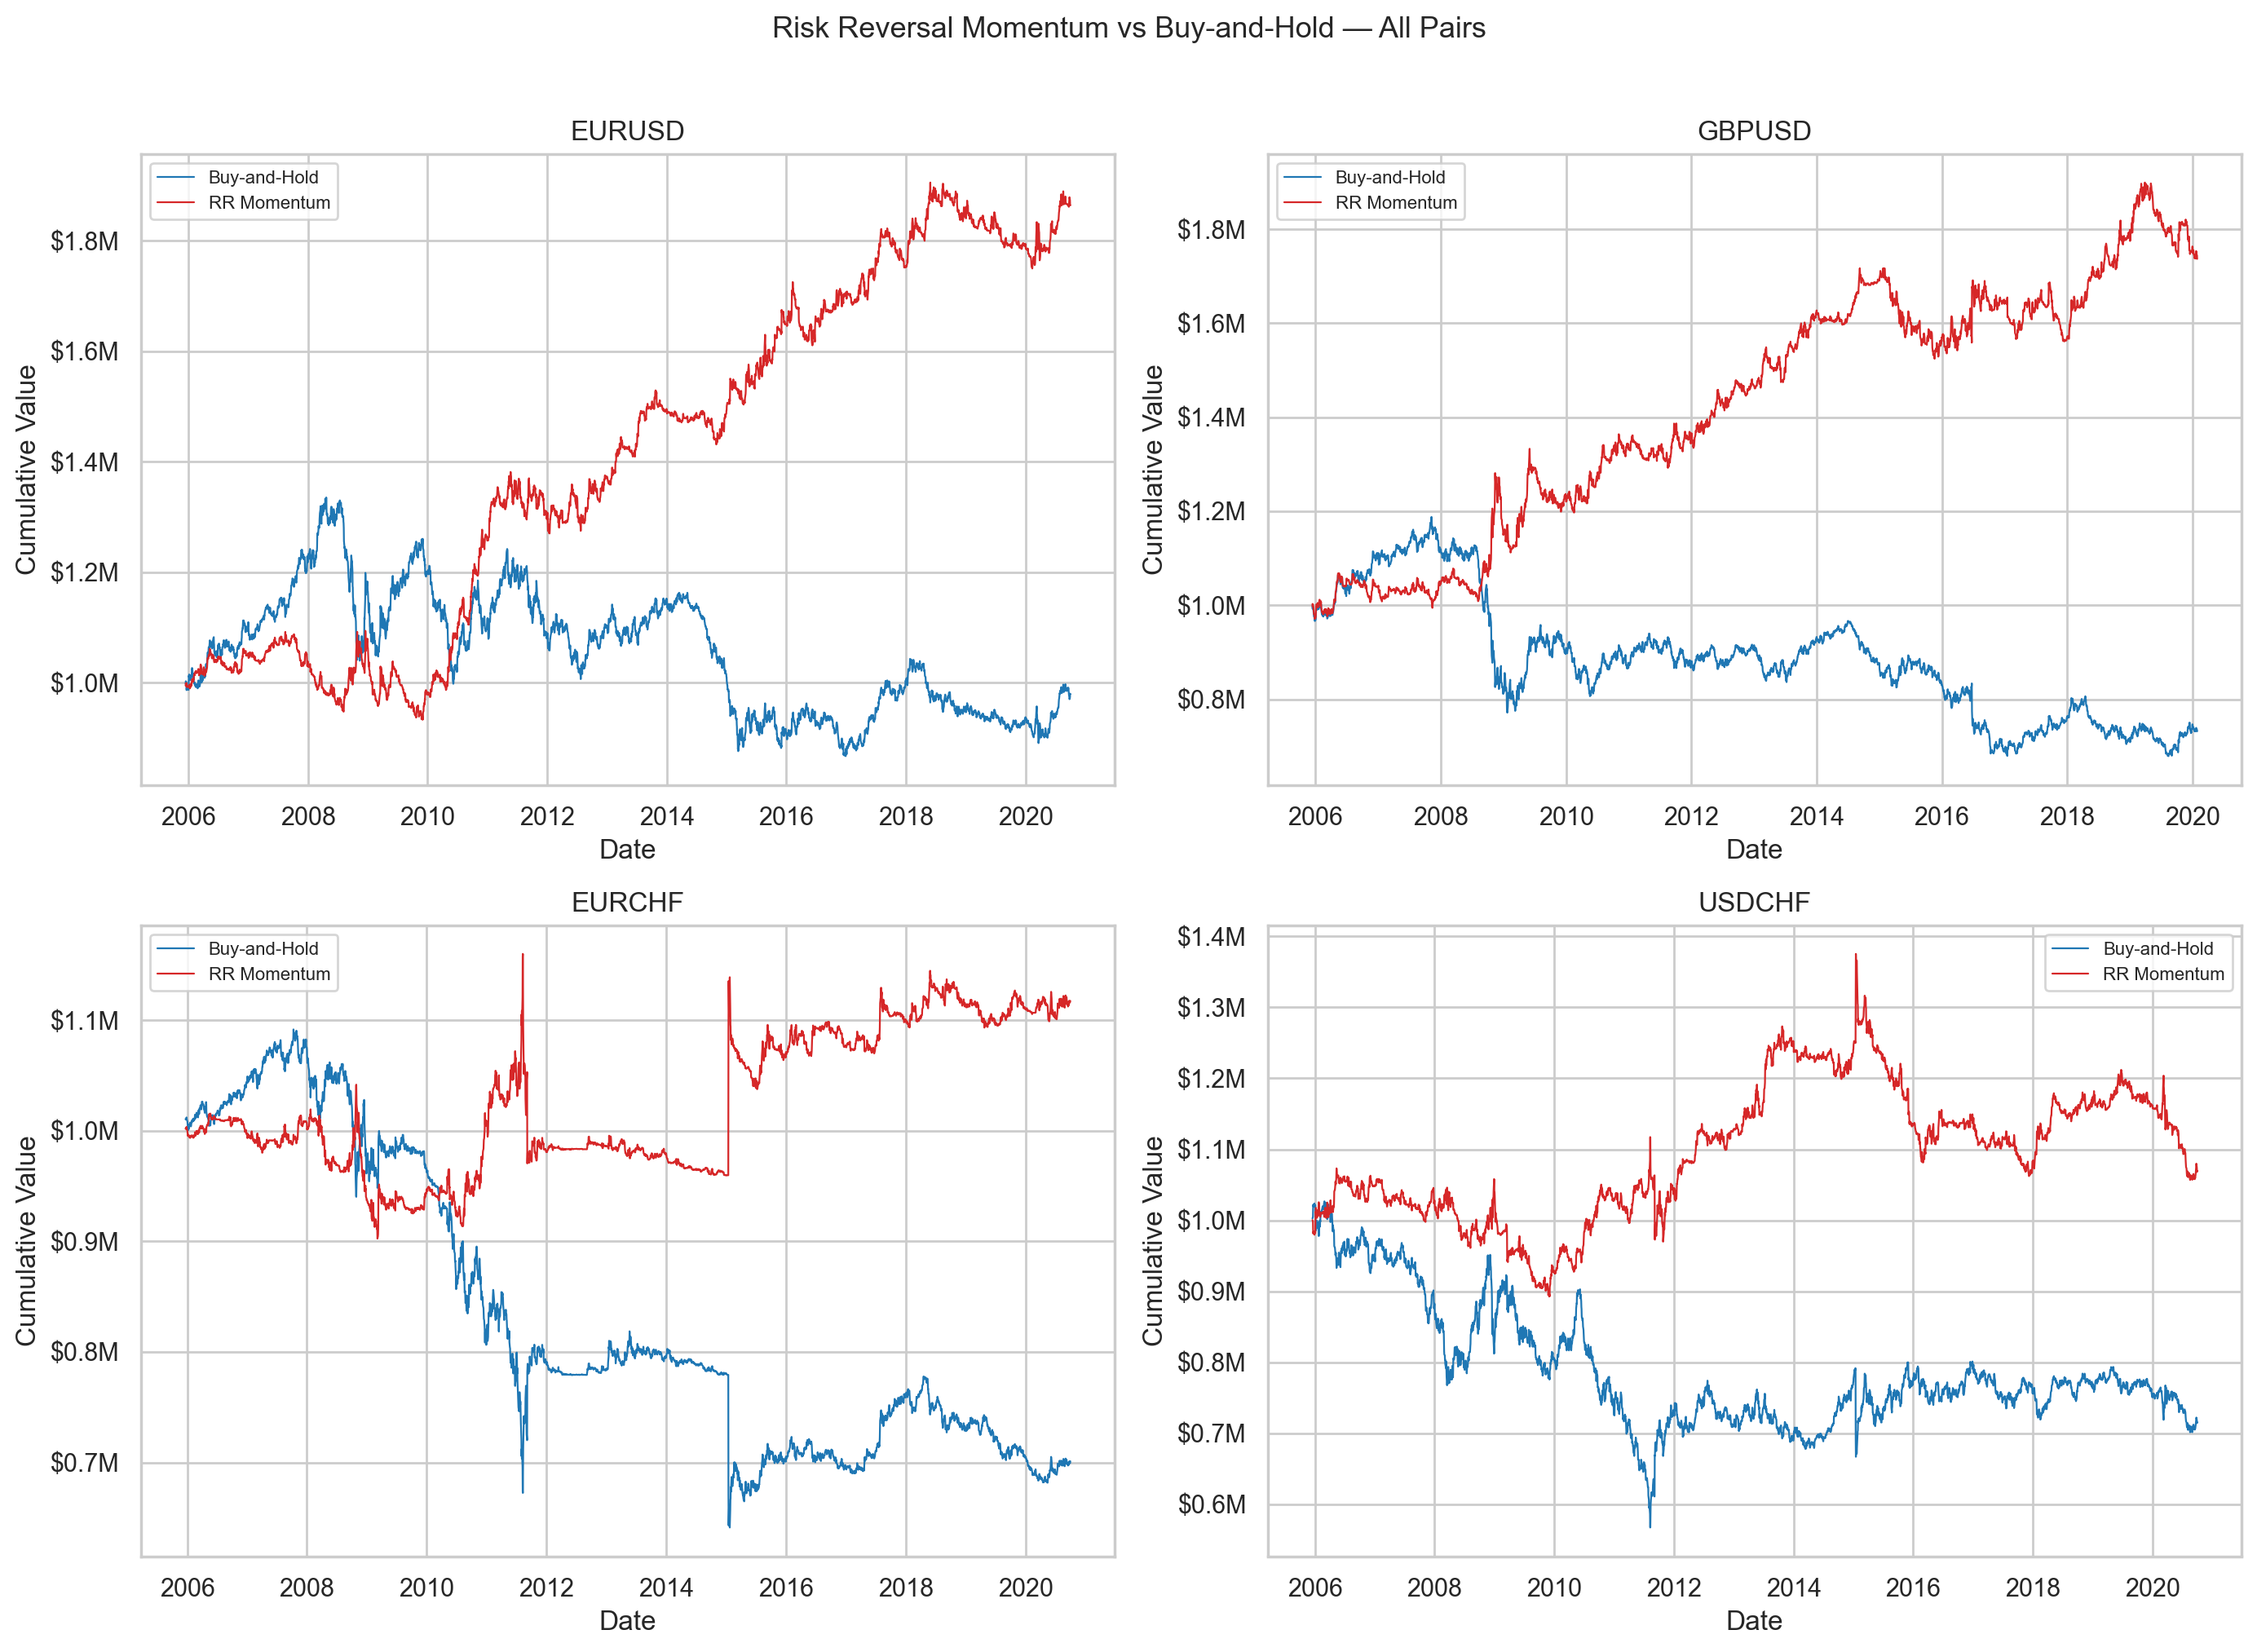

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=False)
axes = axes.flatten()

for ax, sym in zip(axes, PAIRS):
    res = strategies[sym].results.dropna()
    ax.plot(res.index, res["creturns"],  color="#1F77B4", linewidth=0.8, label="Buy-and-Hold")
    ax.plot(res.index, res["cstrategy"], color="#D62728", linewidth=0.8, label="RR Momentum")
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x/1e6:.1f}M"))
    ax.set_title(sym)
    ax.set_xlabel("Date")
    ax.set_ylabel("Cumulative Value")
    ax.legend(fontsize=8)

fig.suptitle(
    "Risk Reversal Momentum vs Buy-and-Hold — All Pairs",
    fontsize=13, y=1.01
)
plt.tight_layout()
plt.show()

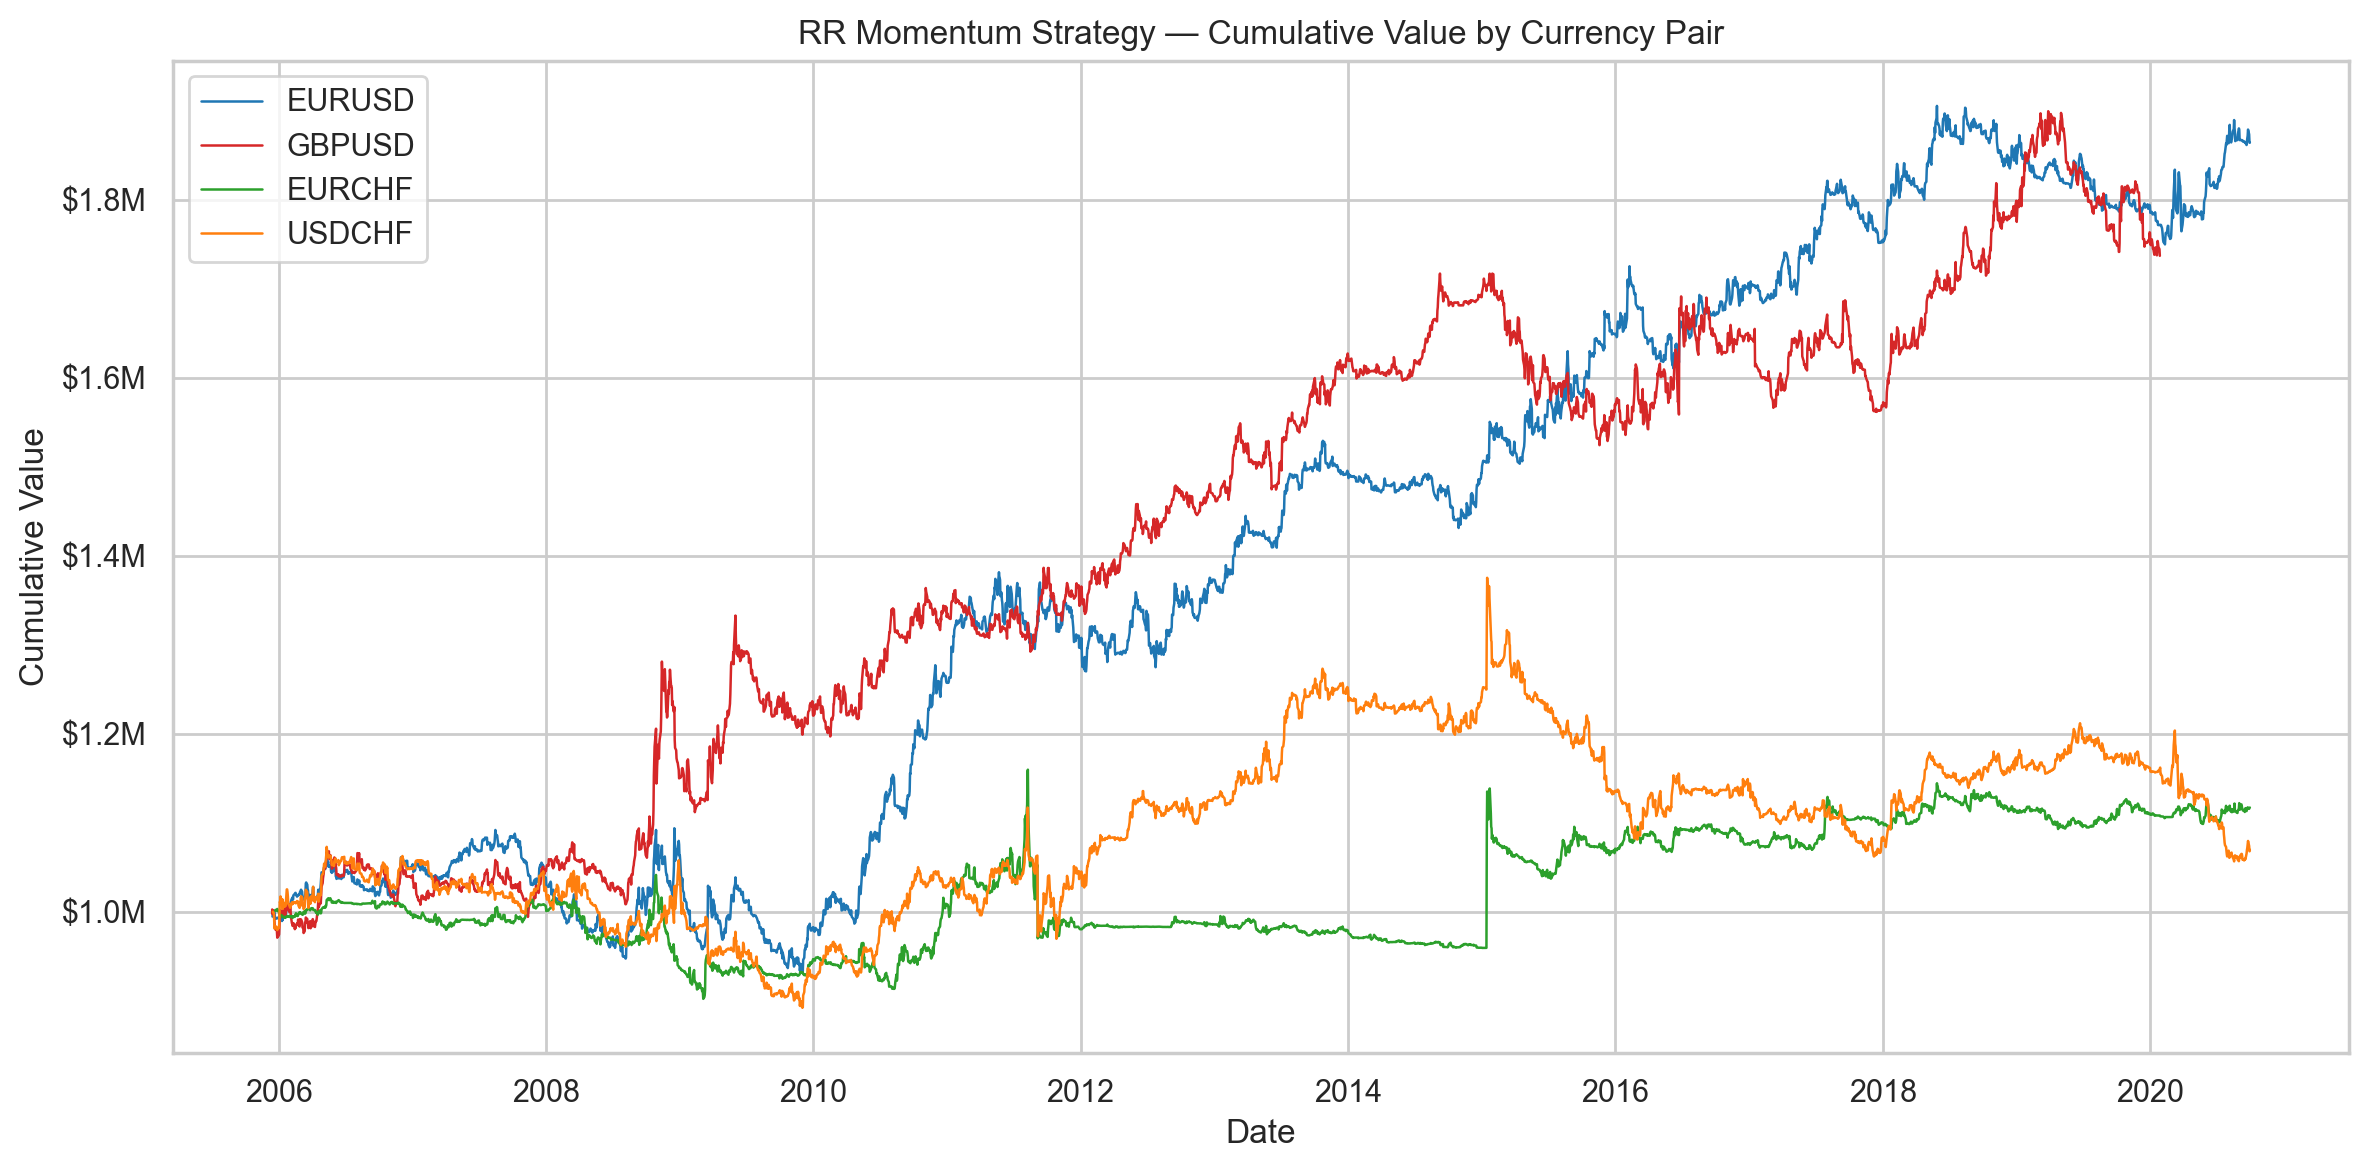

In [37]:
fig, ax = plt.subplots(figsize=(12, 6))

for sym, colour in zip(PAIRS, COLOURS):
    res = strategies[sym].results.dropna()
    ax.plot(res.index, res["cstrategy"], color=colour, linewidth=0.9, label=sym)

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x/1e6:.1f}M"))
ax.set_title("RR Momentum Strategy — Cumulative Value by Currency Pair")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Value")
ax.legend()

plt.tight_layout()
plt.show()

Equal-weight portfolio  |  Sharpe: 0.5356  |  Ann. Return: 2.42%  |  Ann. Vol: 4.52%


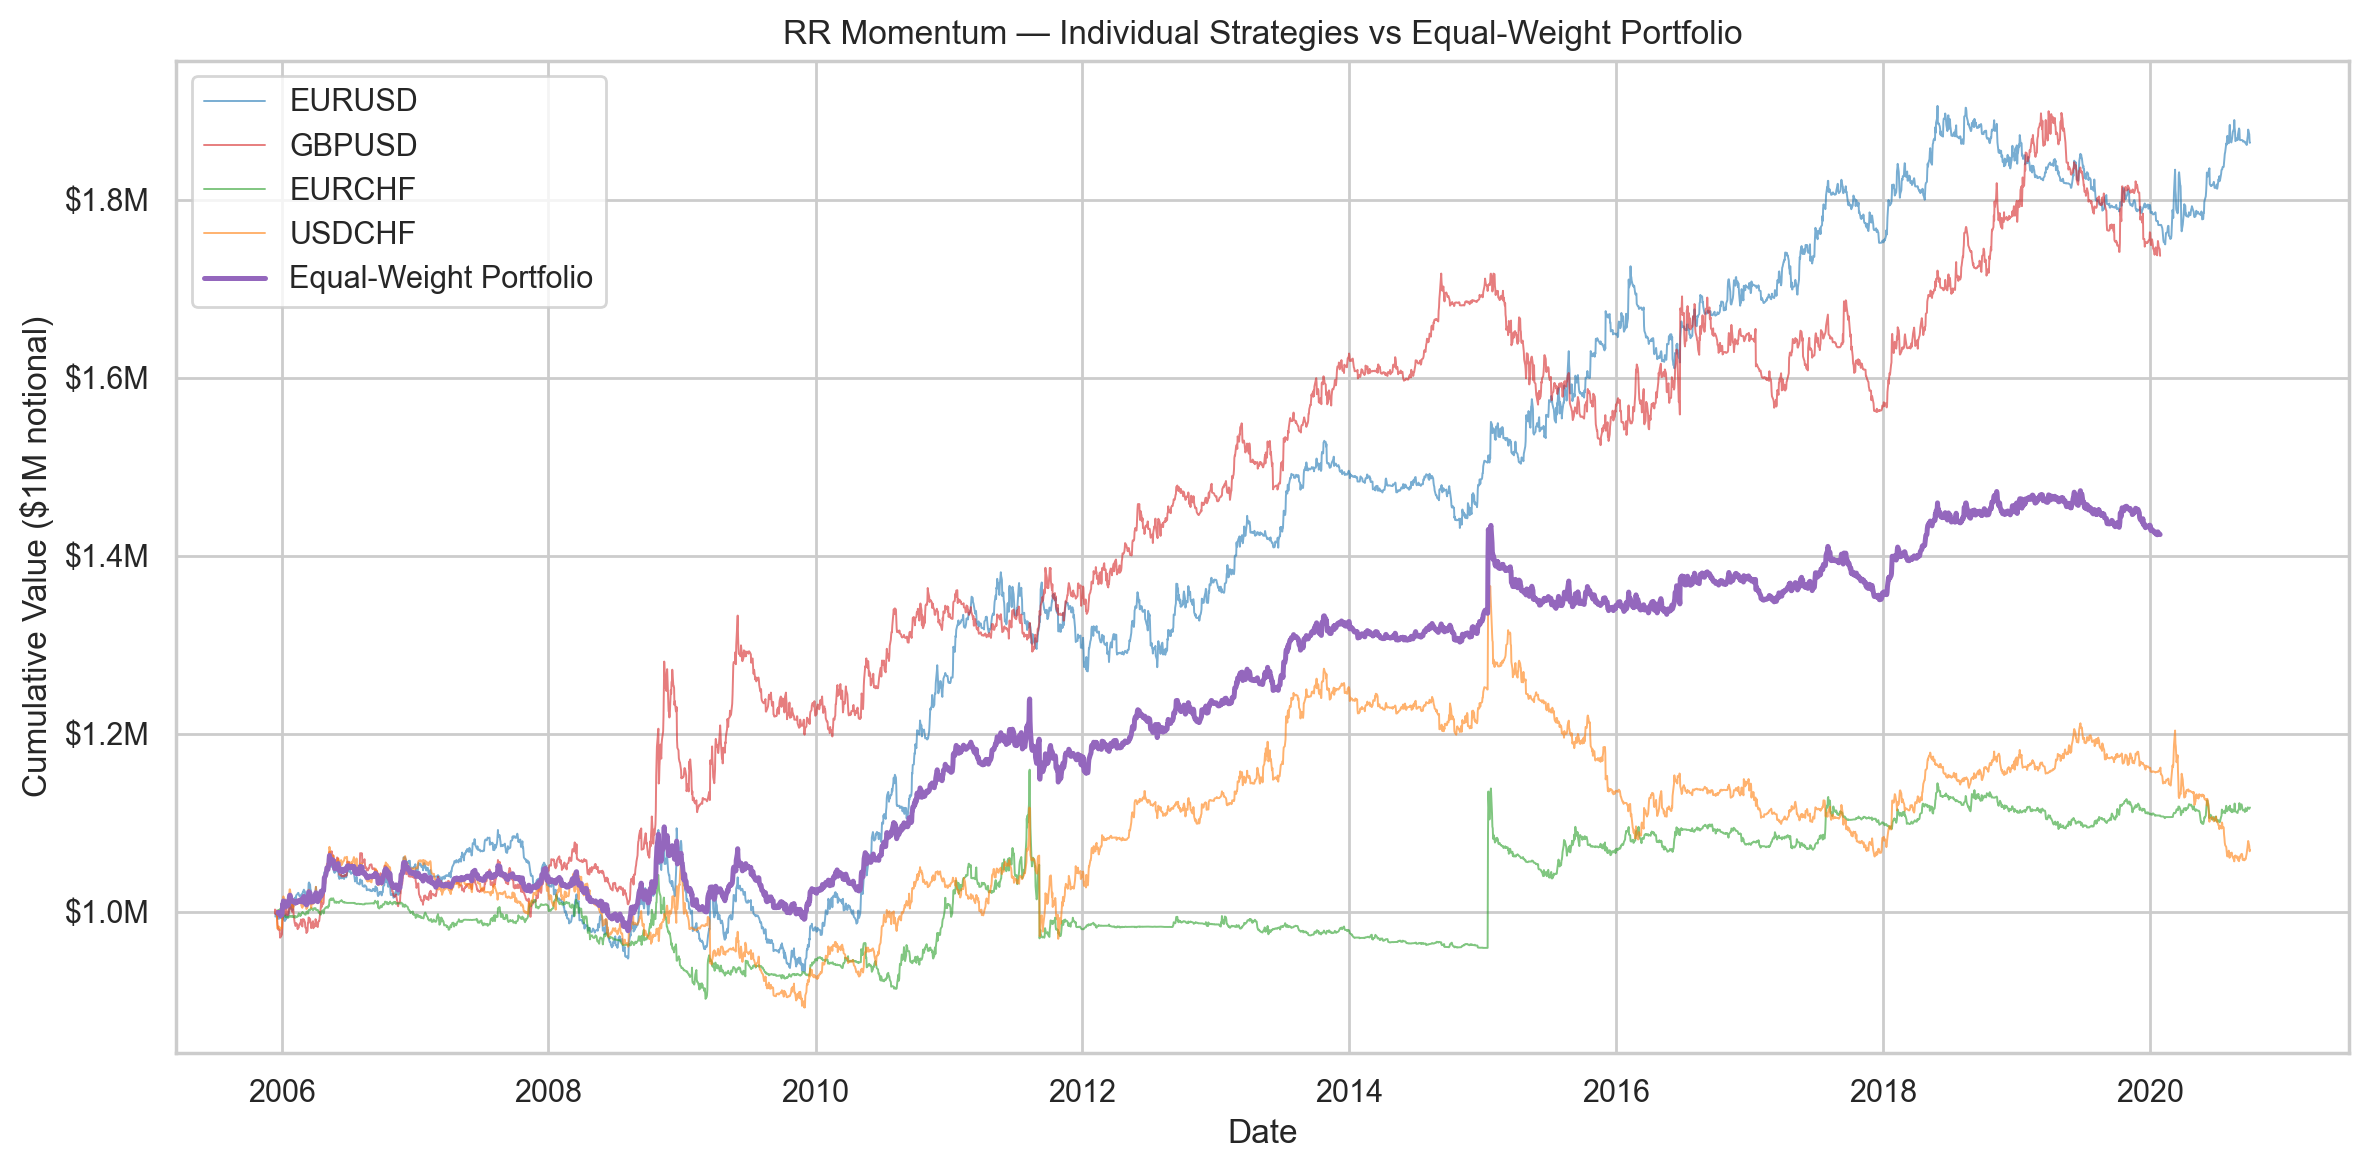

In [38]:
# Align daily strategy returns across all pairs on a common index
daily_returns = pd.concat(
    {sym: strategies[sym].results["strategy"] for sym in PAIRS},
    axis=1
).dropna()

portfolio_returns = daily_returns.mean(axis=1)

ann_ret = portfolio_returns.mean() * 252
ann_vol = portfolio_returns.std()  * np.sqrt(252)
sharpe  = ann_ret / ann_vol
print(f"Equal-weight portfolio  |  Sharpe: {sharpe:.4f}"
      f"  |  Ann. Return: {ann_ret*100:.2f}%"
      f"  |  Ann. Vol: {ann_vol*100:.2f}%")

# Scale to $1M notional for comparison
portfolio_cum = 1_000_000 * portfolio_returns.cumsum().apply(np.exp)

fig, ax = plt.subplots(figsize=(12, 6))

for sym, colour in zip(PAIRS, COLOURS):
    res = strategies[sym].results.dropna()
    ax.plot(res.index, res["cstrategy"],
            color=colour, linewidth=0.7, alpha=0.6, label=sym)

ax.plot(portfolio_cum.index, portfolio_cum.values,
        color="#9467BD", linewidth=1.8, label="Equal-Weight Portfolio")

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x/1e6:.1f}M"))
ax.set_title("RR Momentum — Individual Strategies vs Equal-Weight Portfolio")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Value ($1M notional)")
ax.legend()

plt.tight_layout()
plt.show()

In [39]:
# Collect summary stats for all pairs + equal-weight portfolio
rows = []
for sym in PAIRS:
    res = strategies[sym].results.dropna()
    rows.append(summary_stats(res["return"],   f"{sym} Buy-and-Hold"))
    rows.append(summary_stats(res["strategy"], f"{sym} RR Momentum"))

# Portfolio row
rows.append(summary_stats(portfolio_returns, "Equal-Weight Portfolio"))

cross_pair_stats = pd.DataFrame(rows).set_index("Label")
cross_pair_stats

,Annualised Return,Annualised Vol,Sharpe Ratio,Max Drawdown
Label,,,,
EURUSD Buy-and-Hold,-0.16%,8.87%,-0.0177,-43.17%
EURUSD RR Momentum,4.07%,6.61%,0.6159,-15.90%
GBPUSD Buy-and-Hold,-2.10%,9.35%,-0.2249,-55.95%
GBPUSD RR Momentum,3.78%,7.49%,0.5046,-14.16%
EURCHF Buy-and-Hold,-2.38%,7.51%,-0.3166,-53.20%
EURCHF RR Momentum,0.73%,6.16%,0.1178,-18.95%
USDCHF Buy-and-Hold,-2.21%,10.31%,-0.2141,-59.36%
USDCHF RR Momentum,0.44%,7.08%,0.0623,-26.34%
Equal-Weight Portfolio,2.42%,4.52%,0.5356,-9.96%


### Cross-Pair Analysis

**Diversification.** The equal-weight portfolio benefits from partial decorrelation of signals across pairs. When EURUSD risk reversals shift in a risk-off direction, GBPUSD skew frequently follows (both are EUR/USD bloc proxies), but CHF pairs can move in opposite directions as safe-haven demand compresses EURCHF risk reversals independently of global risk sentiment. This structural diversification tends to reduce portfolio volatility below the arithmetic average of individual pair volatilities, improving the portfolio Sharpe ratio relative to the worst-performing single pair.

**CHF Pairs.** EURCHF and USDCHF risk reversals are disproportionately sensitive to Swiss National Bank policy, EUR area sovereign stress, and global safe-haven flows. During the 2011–2012 Euro crisis and the 2015 SNB floor removal episode (outside this sample), EURCHF risk reversals exhibited extreme skew shifts that do not map cleanly to the same momentum dynamics as G10 risk pairs. As a result, signal quality for CHF pairs is episodic rather than persistent, and their Sharpe ratios tend to be lower and more volatile than for EURUSD and GBPUSD.

**Limitations carried forward from Section 3.** All results assume zero transaction costs and no volatility targeting. A live implementation would require proportional spread costs (typically 2–5 pips for G10 majors, wider for EURCHF), position limits, and dynamic notional scaling to maintain a target realised volatility across the portfolio.